<a href="https://colab.research.google.com/github/hammaad2002/PerturbationAnalysis/blob/main/EEMD_DEFENCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install dsatools
!pip install datasets
!pip install EMD-signal
!pip install python-Levenshtein
!git clone https://github.com/hammaad2002/ASRAdversarialAttacks.git
!git clone https://github.com/hammaad2002/CRDNN_Model.git
%cd /content/ASRAdversarialAttacks/
!pip install -r requirements.txt

In [3]:
from datasets import load_dataset, load_metric
import torchaudio
import torch
from tqdm import tqdm
from ASRAdversarialAttacks.AdversarialAttacks import ASRAttacks
import torchaudio
import torch
import numpy as np
from IPython.display import Audio
from PyEMD import EMD
from PyEMD import EEMD
from PyEMD import CEEMDAN
import Levenshtein
import numpy as np
import pandas as pd
import random

In [4]:
# Set all seeds for reproducibility     
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)  
np.random.seed(0)  
random.seed(0)  
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark = False

In [5]:
%%capture
librispeech_adv_eval = load_dataset("RaphaelOlivier/librispeech_asr_adversarial", "adv", split="adv_0.015")
librispeech_clean_audios = load_dataset("RaphaelOlivier/librispeech_asr_adversarial", "adv", split="natural")

In [6]:
# Loading the model from torchaudio model hub
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model()

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth
100%|██████████| 360M/360M [00:03<00:00, 106MB/s]


In [7]:
# Checking the device available during the current environment (CUDA is recommended!)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [8]:
#initializing attack class
attack = ASRAttacks(model, device, bundle.get_labels())

In [9]:
librispeech_adv_eval

Dataset({
    features: ['file', 'audio', 'true_text', 'target_text', 'id'],
    num_rows: 85
})

In [10]:
librispeech_clean_audios

Dataset({
    features: ['file', 'audio', 'true_text', 'target_text', 'id'],
    num_rows: 85
})

In [11]:
Audio(librispeech_adv_eval['file'][0], rate= 16000)         # perturbed

In [12]:
Audio(librispeech_clean_audios['file'][0], rate= 16000)     # clean

# **Miscellaneous Stuff 1**

In [13]:
authPert = librispeech_adv_eval[4]['audio']['array'] #0.015

In [14]:
authPert = torch.from_numpy(authPert.reshape(1,authPert.size)).float().to(device)

In [15]:
#FGSM PRINT
print("Model Transcription : ",attack.INFER(authPert).replace("|"," "))
print("Target Transcription: ",librispeech_adv_eval[4]['target_text'])
print("Actual Transcription: ",librispeech_adv_eval[4]['true_text'])

Model Transcription :  TAKE THE MET OF WHAT LEGI CRAE SCRAPING OUT ALL OF THE FATRAM THE TEL 
Target Transcription:  TAKE THE MEAT OF ONE LARGE CRAB SCRAPING OUT ALL OF THE FAT FROM THE SHELL
Actual Transcription:  IN THIS CASE AS IN MOST OTHERS WHAT MAY BE TAKEN AS CERTAIN IN ADVANCE IS RATHER VAGUE


In [16]:
groundTruth = librispeech_adv_eval[4]['true_text']
targetText = librispeech_adv_eval[4]['target_text']

In [17]:
print("Targeted WER is: ", attack.wer_compute([targetText], [authPert.cpu().numpy()], targeted= True)[0])
print("Untargeted WER is: ", attack.wer_compute([groundTruth], [authPert.cpu().numpy()], targeted= False)[0])

Targeted WER is:  0.5
Untargeted WER is:  1.0


In [18]:
info = attack.wer_compute([targetText], [authPert.cpu().numpy()], targeted= True)[1]      # TARGETED
print(f"Insertion: {info[0][1]}, Substitution: {info[0][0]}, Deletion: {info[0][2]}") 

Insertion: 0, Substitution: 7, Deletion: 1


In [19]:
info = attack.wer_compute([groundTruth], [authPert.cpu().numpy()], targeted= False)[1]    # UNTARGETED
print(f"Insertion: {info[0][1]}, Substitution: {info[0][0]}, Deletion: {info[0][2]}")

Insertion: 0, Substitution: 15, Deletion: 3


---------------------------------------------------------

# **Miscellaneous Stuff 2**

In [20]:
#parameters
nIMFs = 5 # Number of IMFs
nTrials = 20 # Number of trials

In [21]:
def appEEMD(signal: np.array):
  '''
  Applies EEMD algorithm on input signal
  Arguments:
    signal - 1-D audio array of shape [sequence, ] eg: [1,0.5,0.3]
  
  Returns:
    IMFs, and residue of the signal
  '''
  sr = 16000
  S = signal
  samples = len(S)
  T = np.arange(samples) / sr
  emd = EMD(MAX_ITERATION = nTrials, DTYPE=np.float16, spline_kind='akima')
  eemd = EEMD(trials=nTrials, ext_EMD= emd)
  _    = eemd.eemd(S, T, progress=True, max_imf = nIMFs-1) 
  IMFs, residue = eemd.get_imfs_and_residue() #getting IMFs and residue
  return IMFs, residue

In [22]:
signal = librispeech_adv_eval[4]['audio']['array'] #0.015

In [23]:
IMFs12, residue12 = appEEMD(signal)

EEMD: 100%|██████████| 20/20 [00:31<00:00,  1.58s/it]


In [24]:
emps12 = 0
for i in range(len(IMFs12)):
  emps12 += IMFs12[i] #- 0.1*residue12

In [25]:
print("-"*150)
print("Transcription before anychanges      : ", attack.INFER(authPert).replace("|"," "))
print("Transcription after applying EEMD    : ", attack.INFER(torch.from_numpy(emps12.reshape(1,emps12.size)).float().to(device)).replace("|"," "))
print("-"*150)
print("Ground Truth is                      : ", "".join(groundTruth))

------------------------------------------------------------------------------------------------------------------------------------------------------
Transcription before anychanges      :  TAKE THE MET OF WHAT LEGI CRAE SCRAPING OUT ALL OF THE FATRAM THE TEL 
Transcription after applying EEMD    :  IN THIS CASE AS A MOST OTHERS WHAT MAY BE TAKEN ACIRTNENT ON TE VANIT IS RATHER THOUGH 
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  IN THIS CASE AS IN MOST OTHERS WHAT MAY BE TAKEN AS CERTAIN IN ADVANCE IS RATHER VAGUE


In [26]:
emps12 = 0
for i in range(len(IMFs12)):
  emps12 += IMFs12[i] - 0.1*residue12 #this seem to improve result

In [27]:
print("-"*150)
print("Transcription before anychanges      : ", attack.INFER(authPert).replace("|"," "))
print("Transcription after applying EEMD    : ", attack.INFER(torch.from_numpy(emps12.reshape(1,emps12.size)).float().to(device)).replace("|"," "))
print("-"*150)
print("Ground Truth is                      : ", "".join(groundTruth))

------------------------------------------------------------------------------------------------------------------------------------------------------
Transcription before anychanges      :  TAKE THE MET OF WHAT LEGI CRAE SCRAPING OUT ALL OF THE FATRAM THE TEL 
Transcription after applying EEMD    :  IN THIS CASE AS A MOST OTHERS WHAT MAY BE TAKEN A CERTAIN ON THE THINGT IS RATHER THOUGH 
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  IN THIS CASE AS IN MOST OTHERS WHAT MAY BE TAKEN AS CERTAIN IN ADVANCE IS RATHER VAGUE


# **Main work starts from here**

In [28]:
#parameters
nIMFs = 5 # Number of IMFs
nTrials = 20 # Number of trials

In [29]:
def appEEMD(signal: np.array):
  '''
  Applies EEMD algorithm on input signal
  Arguments:
    signal - 1-D audio array of shape [sequence, ] eg: [1,0.5,0.3]
  
  Returns:
    IMFs, and residue of the signal
  '''
  sr = 16000
  S = signal
  samples = len(S)
  T = np.arange(samples) / sr
  emd = EMD(MAX_ITERATION = nTrials, DTYPE=np.float16, spline_kind='akima')
  eemd = EEMD(trials=nTrials, ext_EMD= emd)
  _    = eemd.eemd(S, T, progress=True, max_imf = nIMFs-1) 
  IMFs, residue = eemd.get_imfs_and_residue() #getting IMFs and residue
  return IMFs, residue

In this we are looking at from the perspective of how much EEMD can recover original transcription from perturbed audios if we are gonna use this as our defense directly instead of detection only.

This is checking the Levenshtein distance and WER changes after applying it on perturbed audios and checking the closeness between after EEMD applied transcription and original clean transcription.

In [30]:
def EEMDTranscription(x:int):
  signal = librispeech_adv_eval[x]['audio']['array']
  groundTruth = librispeech_adv_eval[x]['true_text']
  IMFs12, residue12      = appEEMD(signal)
  emps12 = 0
  for i in range(len(IMFs12)):
    emps12 += IMFs12[i] 
  transcription0 = attack.INFER(torch.from_numpy(signal.reshape(1, signal.size)).float().to(device)).replace("|"," ")
  transcription2 = attack.INFER(torch.from_numpy(emps12.reshape(1, emps12.size)).float().to(device)).replace("|"," ")
  print("Transcription before any changes     : ", transcription0)
  print("Transcription after applying EEMD    : ", transcription2)
  temp = torch.from_numpy(emps12.reshape(1, emps12.size)).float().to(device)
  wer = attack.wer_compute([groundTruth], [temp.cpu().numpy()], targeted= True)[0]        # WER (clean transcription, EEMD signal) or in other words it is transcription match rate(TMR)
  distance = Levenshtein.ratio(transcription2, groundTruth)                               # Levenshtein (clean transcription, EEMD transcription)
  print("WER                  : ", wer * 100)
  print("Levenshtein distance : ", distance * 100)
  info = attack.wer_compute([groundTruth], [temp.cpu().numpy()], targeted= True)[1]         
  print(f"Insertion: {info[0][1]}, Substitution: {info[0][0]}, Deletion: {info[0][2]}")
  print("-"*150)
  print("Ground Truth is                      : ", "".join(groundTruth))
  return wer, distance

In [31]:
wer = []
distance = []
for i in range(85):
  print("*"*150)
  print("-"*150)
  print("*"*150)
  print(str(str(i)+" ITERATION").center(140))
  print("*"*150)
  print("-"*150)
  print("*"*150)
  out = EEMDTranscription(i)
  wer.append(out[0])
  distance.append(out[1])

******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                0 ITERATION                                                                 
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
********************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


Transcription before any changes     :  N WHATS LARS FOR SHE'S ON LIKE FIVE AND TWENTY 
Transcription after applying EEMD    :  AND WHAT SORT OF EDMO CASE LIKE ECONTIMATING 
WER                  :  50.0
Levenshtein distance :  60.86956521739131
Insertion: 0, Substitution: 4, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  AND WHAT SORT OF EVIDENCE IS LOGICALLY POSSIBLE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                    

EEMD: 100%|██████████| 20/20 [00:34<00:00,  1.72s/it]


Transcription before any changes     :  TIS A LETTER IN KANGY AND I AM VERY SORRY FOR IT BUT I'LL SWEAR I KNOW NOT HOW TO HELP IT 
Transcription after applying EEMD    :  REMEMBERING HAVE TO BE A PIKE OF E HURRY AND SOME WAY WITH IT WHEN HOLD WAY WU DO WHAT EDRIN OPIT 
WER                  :  18.181818181818176
Levenshtein distance :  59.183673469387756
Insertion: 5, Substitution: 13, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  REMEMBERING HAS TO BE A PRESENT OCCURRENCE IN SOME WAY RESEMBLING OR RELATED TO WHAT IS REMEMBERED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
********

EEMD: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Transcription before any changes     :  NORI DIARCE  SHET'S ONLY FIVE AND TWENTY 
Transcription after applying EEMD    :  BUT I DO NOT THINK SHAT AL MA MY QUANTY 
WER                  :  50.0
Levenshtein distance :  65.1685393258427
Insertion: 0, Substitution: 5, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  BUT I DO NOT THINK SUCH AN INFERENCE IS WARRANTED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                              

EEMD: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Transcription before any changes     :  NO YEARS FOR SHE'S ONLY FIVLE AND TWETTY 
Transcription after applying EEMD    :  FAMILIARITY WICH A FILLY CAPABLE EPIGY 
WER                  :  42.85714285714286
Levenshtein distance :  70.73170731707317
Insertion: 0, Substitution: 3, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  FAMILIARITY IS A FEELING CAPABLE OF DEGREES
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                       

EEMD: 100%|██████████| 20/20 [00:31<00:00,  1.59s/it]


Transcription before any changes     :  TAKE THE MET OF WHAT LEGI CRAE SCRAPING OUT ALL OF THE FATRAM THE TEL 
Transcription after applying EEMD    :  IN THIS CASE AS IN MOST OTHERS WHAT MAY BE TAK AN ESCIRTENT ON E VANGET TAY RATHER THOUGH 
WER                  :  52.63157894736843
Levenshtein distance :  79.54545454545455
Insertion: 1, Substitution: 8, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  IN THIS CASE AS IN MOST OTHERS WHAT MAY BE TAKEN AS CERTAIN IN ADVANCE IS RATHER VAGUE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***************************************************

EEMD: 100%|██████████| 20/20 [00:31<00:00,  1.60s/it]


Transcription before any changes     :  TAKE THE POT OF UNLAYRD GRBATSCRIN UTOLD HEOF THE FETRO MA THU  HELL 
Transcription after applying EEMD    :  THE FIRST OF OUR VAGUE ATHAT INDIBITABLE DATA THE FETTER OF KNOWLEDGE OF THE CAWL 
WER                  :  37.5
Levenshtein distance :  81.70731707317074
Insertion: 0, Substitution: 9, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THE FIRST OF OUR VAGUE BUT INDUBITABLE DATA IS THAT THERE IS KNOWLEDGE OF THE PAST
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*****************************************************************************

EEMD: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


Transcription before any changes     :  LET ME SAY HO FAIN IT REGINS 
Transcription after applying EEMD    :  A SIGT OF SATE ITS RECOGNITION 
WER                  :  16.666666666666664
Levenshtein distance :  72.1311475409836
Insertion: 1, Substitution: 4, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  A FURTHER STAGE IS RECOGNITION
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                        

EEMD: 100%|██████████| 20/20 [00:35<00:00,  1.78s/it]


Transcription before any changes     :  SYCA THE MEIT OF ONE CLERGE CRAB SCREP OUT ALL OF THE APHETO FROM THE OAS HELL 
Transcription after applying EEMD    :  SOMETHINATS MAY BE TOCENE TIRK AMB STRECK OUT IN THE AFETO FROMAS ARASHEL 
WER                  :  0.0
Levenshtein distance :  58.06451612903225
Insertion: 0, Substitution: 13, Deletion: 4
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  SOME POINTS MAY BE TAKEN AS FIXED AND SUCH AS ANY THEORY OF MEMORY MUST ARRIVE AT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
****************************************************************************

EEMD: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


Transcription before any changes     :  AT IS LOLAS THE LINLY AND LIEUTENANT COULD BEAR THE ANXITY NO LONGER 
Transcription after applying EEMD    :  IT IS KNOWLEDGE A MEMORY IN ONE THING THOUGH IN ANATTHER IT IS NOWED 
WER                  :  0.0
Levenshtein distance :  83.5820895522388
Insertion: 1, Substitution: 13, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THIS KNOWLEDGE IS MEMORY IN ONE SENSE THOUGH IN ANOTHER IT IS NOT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:31<00:00,  1.58s/it]


Transcription before any changes     :  TAKE SOME IMITATE OF ONE LIGAND CRAME SCRAPIONG UT ALSO THE MILATE FROM OTHER  SHELL 
Transcription after applying EEMD    :  SOME IMITATES LIKE SENSENSATION TILL VERY FAMILIAR WHILE OTHERS FORL CHANGE 
WER                  :  16.666666666666664
Levenshtein distance :  83.66013071895425
Insertion: 0, Substitution: 9, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  SOME IMAGES LIKE SOME SENSATIONS FEEL VERY FAMILIAR WHILE OTHERS FEEL STRANGE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
**********************************************************

EEMD: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Transcription before any changes     :  WHAT OF TES NOT A MAN UNDERGO FOR THE SAKE OF ACURE 
Transcription after applying EEMD    :  IT AVETS THAT A VEVENTUAL SECHEORY OF KNOWLEDGE 
WER                  :  9.090909090909093
Levenshtein distance :  67.32673267326732
Insertion: 0, Substitution: 7, Deletion: 3
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  IT IS THIS THAT IS OF INTEREST TO THEORY OF KNOWLEDGE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
************************************************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


Transcription before any changes     :  TAGGY THE MEAT OF UDEE LARGE CRAGE SCRAPPING OUT ALL OF THE FATERPLACE SHELL 
Transcription after applying EEMD    :  A GAV T THE SPEAT OF EVERYDAY LARGE FOBOT CARRYING OT ON THE TON E APROPLATION 
WER                  :  18.75
Levenshtein distance :  62.96296296296296
Insertion: 1, Substitution: 12, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  AS USED IN THE SPEECH OF EVERYDAY LIFE THE WORD CARRIES AN UNDERTONE OF DEPRECATION
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*********************************************************************

EEMD: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


Transcription before any changes     :  TO SAY THERE IN CHANGES AN I AM VERY SORRY FOR IT BUT I ILL SWEAR I KNOW NOT HOW TO HELP IT 
Transcription after applying EEMD    :  TO SAY THEIR CHACES OF THIS GAVERISON WOR DOMESTIC SLET OF HAVALREADY BEINDEPENTED 
WER                  :  0.0
Levenshtein distance :  65.49707602339181
Insertion: 0, Substitution: 13, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THE SALIENT FEATURES OF THIS DEVELOPMENT OF DOMESTIC SERVICE HAVE ALREADY BEEN INDICATED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***********************************************

EEMD: 100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


Transcription before any changes     :  TAKE THE GIMMAL WAY ONO ON LARDE GRAB GRAPING OU HE OVE THE FAT FROM THE SHELL 
Transcription after applying EEMD    :  IN A GENERAL WAY THOUGH NOT ONLY IN OR CONFRICTION OTY TO THE GREE FROM SHA 
WER                  :  37.5
Levenshtein distance :  70.58823529411764
Insertion: 3, Substitution: 7, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  IN A GENERAL WAY THOUGH NOT WHOLLY NOR CONSISTENTLY THESE TWO GROUPS COINCIDE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************

EEMD: 100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


Transcription before any changes     :  TAKE THE METON SLAR GRABS GREOPING OUT ALL OF THE EARNE FATE FROM THE SHELL 
Transcription after applying EEMD    :  TEEK TE MAR COCLERC ABOUT EQIN OUTI OF THE EARLIEST FATAL OF THE SHUWEL 
WER                  :  21.42857142857143
Levenshtein distance :  51.57232704402516
Insertion: 0, Substitution: 11, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  EACH WILL THEREFORE SERVE ABOUT EQUALLY WELL DURING THE EARLIER STAGES OF SOCIAL GROWTH
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*************************************************************

EEMD: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


Transcription before any changes     :  IS A THRE GENGLE AND I AM VERY SORRY FOR IT BUT I'LL FOUND I KNOW NOT IALL TO HELP I 
Transcription after applying EEMD    :  IN THE COMMUNITY OF THE WITH IM PER THERY POINT WIT TE HIG AND FOUND IN ON THE LON OF A PIE 
WER                  :  18.181818181818176
Levenshtein distance :  64.24870466321244
Insertion: 4, Substitution: 14, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  IN THE COMMUNITIES OF THE WESTERN CULTURE THIS POINT IS AT PRESENT FOUND AMONG THE LOWER MIDDLE CLASS
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*****************

EEMD: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


Transcription before any changes     :  TIE SOSTRING A CANTENAGE AND I AM VERY SORRY FOR IT BUT ELSEWHERE I KNOW NOT HOW TO HELP IT 
Transcription after applying EEMD    :  TIM SOME SHING TO COMES TO LODGE I AN AM VERY SOUNDRY OF HIBEN AND SWEEPI ON OT A TOMETED 
WER                  :  0.0
Levenshtein distance :  46.7391304347826
Insertion: 3, Substitution: 17, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  CONSUMPTION BECOMES A LARGER ELEMENT IN THE STANDARD OF LIVING IN THE CITY THAN IN THE COUNTRY
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***********************************

EEMD: 100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


Transcription before any changes     :  THE BURGIS IT WOT CARE MUCH ABOUT BEING BURIAD IN THE FAGIRAD IT HIGHTED AT POVERTY WHER PLECASISA IF YOU PLEASE 
Transcription after applying EEMD    :  THE POT WHICH IF WHICH CORE TOIM OT EXPERIENC IN THE OERDE IT FINT HIS INT CONVERTY FARLAASISIDE IF YOU PLASE 
WER                  :  4.761904761904767
Levenshtein distance :  50.0
Insertion: 0, Substitution: 20, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THE QUESTION IS WHICH OF THE TWO METHODS WILL MOST EFFECTIVELY REACH THE PERSONS WHOSE CONVICTIONS IT IS DESIRED TO AFFECT
******************************************************************************************************************************************************
-------------------------------------------------------------------------------------------------------------------

EEMD: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


Transcription before any changes     :  TAKE THE MUDOFOGANELE A CABLES GRAFINGERI OF THE VADRAN EZELL 
Transcription after applying EEMD    :  THE MUDEN ORGANIZATION OF INDUSTRY WAS IN THE FAIN DIRECTION OF THE VALU OF ELAN 
WER                  :  46.666666666666664
Levenshtein distance :  77.57575757575758
Insertion: 1, Substitution: 7, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THE MODERN ORGANIZATION OF INDUSTRY WORKS IN THE SAME DIRECTION ALSO BY ANOTHER LINE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*********************************************************************

EEMD: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


Transcription before any changes     :  TIS A STRANGE CHANGE AND I AM VERY SORRY VERTED BUT I'LL SWEAR I KNOW NOT HOW TO HELP IS 
Transcription after applying EEMD    :  TIS APRENTIATION I VERTED BY BE INHERITED WIT WEALTH BY RECONSEQUENC ON HOW TO HELPATISM 
WER                  :  13.33333333333333
Levenshtein distance :  65.64102564102564
Insertion: 0, Substitution: 13, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THIS DIFFERENTIATION IS FURTHERED BY THE INHERITANCE OF WEALTH AND THE CONSEQUENT INHERITANCE OF GENTILITY
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
************

EEMD: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it]


Transcription before any changes     :  THE LITEALY FRON TE NAND ALBIARE THE ANXIETY NO LANGER 
Transcription after applying EEMD    :  THE LIVERY BECOMES ABUPTIOVE TO MAY ALL BEARLY QUIETUARY 
WER                  :  38.46153846153846
Levenshtein distance :  69.29133858267717
Insertion: 0, Substitution: 4, Deletion: 4
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THE LIVERY BECOMES OBNOXIOUS TO NEARLY ALL WHO ARE REQUIRED TO WEAR IT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*******************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


Transcription before any changes     :  AT LEFT THE GLITTLE LIEUTENANT NO CUL MOT THE ANGETE NO LONGER 
Transcription after applying EEMD    :  LET THE GENERAL OF THE PINTON IS NOT FROM AT THE COUNT TOG LO E LOT 
WER                  :  12.5
Levenshtein distance :  68.14814814814815
Insertion: 4, Substitution: 10, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  BUT THE GENERAL DISTINCTION IS NOT ON THAT ACCOUNT TO BE OVERLOOKED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Transcription before any changes     :  HE IS IL STRANGE TANGE AND I AM E VERY SORRY FOR YET BUT I'LL WHERE I KNOW NOT HOW TO HELP IT 
Transcription after applying EEMD    :  THE ADILITY OF CONFUNTION I CAN EVIDATE WI WEALTH IF TO THE CLASS WERE A JURY BUTTER GROWTH 
WER                  :  27.77777777777778
Levenshtein distance :  72.1311475409836
Insertion: 1, Substitution: 12, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THE UTILITY OF CONSUMPTION AS AN EVIDENCE OF WEALTH IS TO BE CLASSED AS A DERIVATIVE GROWTH
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
********************

EEMD: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


Transcription before any changes     :  IT IS VELLE ENOUGH ELABORETH THE CHENYOU WELL CARRY HER OUT 
Transcription after applying EEMD    :  IT WAS MORE ENOUGH DELABORATE TIGENOL WRICAN GRAPE 
WER                  :  0.0
Levenshtein distance :  60.0
Insertion: 0, Substitution: 8, Deletion: 4
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THERE IS A MORE OR LESS ELABORATE SYSTEM OF RANK AND GRADES
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
   

EEMD: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


Transcription before any changes     :  TAKE THE MAT OF ONE LUXURY AMSCRAPING OTILE THE RANT FROM THE LEGER HELL 
Transcription after applying EEMD    :  IN THE NATURE OF TE LEXURY AND THE CONFLICTS OF LIFE THE LUN OF THE LEGERD HEATH 
WER                  :  47.05882352941176
Levenshtein distance :  73.49397590361446
Insertion: 1, Substitution: 8, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  IN THE NATURE OF THINGS LUXURIES AND THE COMFORTS OF LIFE BELONG TO THE LEISURE CLASS
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
**********************************************************

EEMD: 100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


Transcription before any changes     :  TIS ASRINGOOKANGI AND I AM VERO SORRY FOR IT BUT HELLS VERY HONOTER TO HELP IT 
Transcription after applying EEMD    :  THEY DREW BACK A LITTLE FROM THE ENTRANCE AND MOTIONED FOR THE SUPPOSED CONJUROR TO ENTER 
WER                  :  87.5
Levenshtein distance :  96.62921348314607
Insertion: 0, Substitution: 2, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THEY DREW BACK A LITTLE FROM THE ENTRANCE AND MOTIONED TO THE SUPPOSED CONJURER TO ENTER
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*****************************************************

EEMD: 100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


Transcription before any changes     :  AT LAGE TUT THE FLAGGYS LIE LENANDA WELLDBE THEM ANCIENT NO LONGER 
Transcription after applying EEMD    :  THE BEAR SHUT THIS SHAGGY SIDES AND MEN A WELL KNOWN VOICE REPLIED 
WER                  :  76.92307692307692
Levenshtein distance :  92.53731343283582
Insertion: 0, Substitution: 3, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THE BEAR SHOOK HIS SHAGGY SIDES AND THEN A WELL KNOWN VOICE REPLIED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


Transcription before any changes     :  TOCRALEGU CANGANDO AESORI FA OUR FIT BUT I'LL SWEAR I KNOWS NOT O TO HELP IT 
Transcription after applying EEMD    :  WHAT SHALL WE DO WITH THE MINDOS AT E DOR TAKEN OUT SIX AND THE SING RITES AS GOOD AS NOTHING 
WER                  :  61.904761904761905
Levenshtein distance :  88.54166666666666
Insertion: 0, Substitution: 8, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  WHAT SHALL WE DO WITH THE MINGOES AT THE DOOR THEY COUNT SIX AND THIS SINGER IS AS GOOD AS NOTHING
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***************************

EEMD: 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


Transcription before any changes     :  LET ME SEE HOW CAN IT BUNGIN 
Transcription after applying EEMD    :  LEV A HERIN KINIS BRUNGIN 
WER                  :  0.0
Levenshtein distance :  45.614035087719294
Insertion: 0, Substitution: 5, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  WILL THE HURONS HEAR HIS GROANS
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                29 ITERAT

EEMD: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


Transcription before any changes     :  TELK WHAT CAN'T HAVE DONE LY NAME SCRABE HES OLL I OUT OLD NOF THY FET FROM THY SHELL 
Transcription after applying EEMD    :  WELL WHAT CAN'T BE DONE BY MAIN COURAGING OR MUST BE DONE BY CIRCUMVENGEL 
WER                  :  46.666666666666664
Levenshtein distance :  90.66666666666666
Insertion: 0, Substitution: 7, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  WELL WHAT CAN'T BE DONE BY MAIN COURAGE IN WAR MUST BE DONE BY CIRCUMVENTION
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
************************************************************

EEMD: 100%|██████████| 20/20 [00:37<00:00,  1.89s/it]


Transcription before any changes     :  I HE TRANLYGENERAL CHANGE YO FOUD I AM MY VERY THORY FOR IT BUT IN LARS WERE I KNOW NOT HOW TO SURV IT 
Transcription after applying EEMD    :  BRAVELY AND GENEROUSLY AS HE BATTLED IN MY BEHALF AND THIS AND MORE WERE I DARE IN HIS SERVICE 
WER                  :  89.47368421052632
Levenshtein distance :  95.78947368421052
Insertion: 0, Substitution: 2, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  BRAVELY AND GENEROUSLY HAS HE BATTLED IN MY BEHALF AND THIS AND MORE WILL I DARE IN HIS SERVICE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
****

EEMD: 100%|██████████| 20/20 [00:34<00:00,  1.71s/it]


Transcription before any changes     :  ON TIS YO TERCATE THE LEAG AND I WILL EVER LORY FOR IT BUT ILL SWELL I KNOW NOT HOW TO HELP IT 
Transcription after applying EEMD    :  SO ON THIS YOU HAD BETTER TAKE THE LEAV WOL I WILL PUT ON A SKIIN AGAIN AND THRUST TIN HIM H OR WANT OF SPEED 
WER                  :  3.8461538461538436
Levenshtein distance :  84.16289592760181
Insertion: 2, Substitution: 23, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  SO UNCAS YOU HAD BETTER TAKE THE LEAD WHILE I WILL PUT ON THE SKIN AGAIN AND TRUST TO CUNNING FOR WANT OF SPEED
******************************************************************************************************************************************************
----------------------------------------------------------------------------------------------------------------------------------

EEMD: 100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


Transcription before any changes     :  TI A STRANGE CHAIRANGE MAND I GAM VERY HURRY FOR IT BOUT I'LL UTTER IN NEWN OF THES WAY TO THE CMIND 
Transcription after applying EEMD    :  TILL AS SUMETHING IN HIS HAIR AND MANNER HET BETRAYED FOT HI SPOUT HE UTTERED CONFUSION OF THE SWAY OF HIS MIND 
WER                  :  50.0
Levenshtein distance :  86.22222222222223
Insertion: 0, Substitution: 11, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THERE WAS SOMETHING IN HIS AIR AND MANNER THAT BETRAYED TO THE SCOUT THE UTTER CONFUSION OF THE STATE OF HIS MIND
******************************************************************************************************************************************************
--------------------------------------------------------------------------------------------------------------------------------------

EEMD: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


Transcription before any changes     :  TIS A STRANGE CHANGE TURNED AIL AN VREASONS ORTHRE FOR IT BUT I'LL SWEAR I NOW NOT HOW TO HELP IT 
Transcription after applying EEMD    :  CAN THES BIN HAY RETURNED DAVID BREATHING MORE FREELY AT WE TRUTHFUL MAN E DAWN UPON WHOM 
WER                  :  47.05882352941176
Levenshtein distance :  83.51648351648352
Insertion: 0, Substitution: 9, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  CAN THESE THINGS BE RETURNED DAVID BREATHING MORE FREELY AS THE TRUTH BEGAN TO DAWN UPON HIM
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*****************

EEMD: 100%|██████████| 20/20 [00:21<00:00,  1.10s/it]


Transcription before any changes     :  THE YOUNG MAN IT A LIAGE TAND NHY COULD I BEAR THE ANXIETY OF LHEGRE 
Transcription after applying EEMD    :  THE YOUNG MAN IS IN BONDAGE AND MUCH I FEAR HIS DEATH IS DECREED 
WER                  :  100.0
Levenshtein distance :  99.2248062015504
Insertion: 0, Substitution: 0, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THE YOUNG MAN IS IN BONDAGE AND MUCH I FEAR HIS DEATH IS DECREED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
****************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


Transcription before any changes     :  THEN A STRINGT CLADAND I AM VERY SORRY FOR IT BUT O LESS WEARS I KNOW NOT HO TO HELP IT 
Transcription after applying EEMD    :  THEN AS IF SATISFIED OF THEIR SAFETY THE SCOUT LEFT HIS POSITION OF SLOWLY INTER THE PLACE 
WER                  :  88.23529411764706
Levenshtein distance :  94.56521739130434
Insertion: 0, Substitution: 2, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THEN AS IF SATISFIED OF THEIR SAFETY THE SCOUT LEFT HIS POSITION AND SLOWLY ENTERED THE PLACE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*************************

EEMD: 100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


Transcription before any changes     :  SAT OUSEVSNOT A MAK NORAGO FOR THE SAR OF FURI 
Transcription after applying EEMD    :  SIT USE FOR YOURSELF AND MAKE A RUSH OR TARIVURY 
WER                  :  54.54545454545454
Levenshtein distance :  80.0
Insertion: 0, Substitution: 4, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  SO CHOOSE FOR YOURSELF TO MAKE A RUSH OR TARRY HERE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
            

EEMD: 100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Transcription before any changes     :  TI SOON IS IS ISTRANG A CHANGE MAN I AM VERY SORRY FOR IT WIT ALANS WHERE I KNOW NOT WHO TO HELP IT 
Transcription after applying EEMD    :  AS SOON AS THESE DISPOSITIONS WERE MADE FOR SCOUT FRINTEL DAVIN ENGAVING HIS PART ON ENSTRUCTION 
WER                  :  44.44444444444444
Levenshtein distance :  82.0
Insertion: 0, Substitution: 8, Deletion: 2
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  AS SOON AS THESE DISPOSITIONS WERE MADE THE SCOUT TURNED TO DAVID AND GAVE HIM HIS PARTING INSTRUCTIONS
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
**********

EEMD: 100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


Transcription before any changes     :  A DOUBLE AS THE CILDELON TORDITS ON THE ANC NO LONGEAR 
Transcription after applying EEMD    :  THE DELAWARES ARE CHILDREN OF THE TORTOISE AND THE OUTSCI FEGEER 
WER                  :  66.66666666666667
Levenshtein distance :  91.04477611940298
Insertion: 0, Substitution: 3, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THE DELAWARES ARE CHILDREN OF THE TORTOISE AND THEY OUTSTRIP THE DEER
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


Transcription before any changes     :  TAKE THERE ISTEAD OF OLARGE CRAB CRAMING OUT L OF THE PHATE FROM THE SHELL 
Transcription after applying EEMD    :  TAKE THE BEAR INSTEAD OF ABAING TAIN RAIN OF THE FEET OF THE FACIN FROM THE JOWL 
WER                  :  23.529411764705888
Levenshtein distance :  66.24203821656052
Insertion: 3, Substitution: 10, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  BUT THE BEAR INSTEAD OF OBEYING MAINTAINED THE SEAT IT HAD TAKEN AND GROWLED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***************************************************************

EEMD: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


Transcription before any changes     :  AT LEAST THE ASTL LIEUTENANT COUT BOARTHIAS N YELOW ORGER 
Transcription after applying EEMD    :  UNCAS CASSE HIS SKIN AND STEPPED FORTH IN HIS OWN BEAUTIFUL PROPORTIONS 
WER                  :  91.66666666666666
Levenshtein distance :  97.1830985915493
Insertion: 0, Substitution: 1, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  UNCAS CAST HIS SKIN AND STEPPED FORTH IN HIS OWN BEAUTIFUL PROPORTIONS
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
**************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


Transcription before any changes     :  TIS AT TREEER AND WE ISAN A SHOR GRAVE OR ITS ILLNS WHERE I NOW NOT SIG  TO OR HELP ART 
Transcription after applying EEMD    :  YET HERE ARE WE WITHIN A SHORT RANGE OF ITS BALLOONS AND NOT A SIGN OF A TRAIL HAV COSS 
WER                  :  76.19047619047619
Levenshtein distance :  90.10989010989012
Insertion: 0, Substitution: 4, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  YET HERE ARE WE WITHIN A SHORT RANGE OF THE SCAROONS AND NOT A SIGN OF A TRAIL HAVE WE CROSSED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***************************

EEMD: 100%|██████████| 20/20 [00:21<00:00,  1.05s/it]


Transcription before any changes     :  AND LTHE LITTLE WOUT HAD BEEN COLD ON BERTHE HADI SALY NO LONGER  
Transcription after applying EEMD    :  IT WOULD HAVE BEEN MORE WONDERFUL HAD HE SPOKEN WITHOUT OPINION 
WER                  :  83.33333333333334
Levenshtein distance :  91.47286821705426
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  IT WOULD HAVE BEEN MORE WONDERFUL HAD HE SPOKEN WITHOUT A BIDDING
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


Transcription before any changes     :  RIV TAT ISAS HE ENHRANGE WITH THE CHILD YOU WILL CARRY HER OUT 
Transcription after applying EEMD    :  RUN BACK AN AS CAN BRING YOU WITH THE SIZE YOU WILL SE ME HER FOOT 
WER                  :  12.5
Levenshtein distance :  69.35483870967742
Insertion: 4, Substitution: 10, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  RUN BACK UNCAS AND BRING ME THE SIZE OF THE SINGER'S FOOT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
**************************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


Transcription before any changes     :  NEW GERINATION HOWESE HE'S ALL FIT UNDER TWENTY 
Transcription after applying EEMD    :  THE EXAMINATION HOWEVER RESULTED IN MODETWEBLY 
WER                  :  71.42857142857143
Levenshtein distance :  84.21052631578947
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THE EXAMINATION HOWEVER RESULTED IN NO DISCOVERY
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
   

EEMD: 100%|██████████| 20/20 [00:33<00:00,  1.66s/it]


Transcription before any changes     :  TASA OSTRU HANGER CHANGENCE I AM VERY SODRY FOR IT BAUTILSWEAR I KNOW NOT HOW TO HELP IT 
Transcription after applying EEMD    :  A CIRCLE OF A FEW HUNDRED FEET IN CIRCUMVERCE WAS DRAW A MUTULOUS PARTY TOOK A SEBNULT FOR IS FORTUNT 
WER                  :  40.90909090909091
Levenshtein distance :  82.0754716981132
Insertion: 0, Substitution: 11, Deletion: 2
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  A CIRCLE OF A FEW HUNDRED FEET IN CIRCUMFERENCE WAS DRAWN AND EACH OF THE PARTY TOOK A SEGMENT FOR HIS PORTION
******************************************************************************************************************************************************
---------------------------------------------------------------------------------------------------------------------------------------------------

EEMD: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


Transcription before any changes     :  AN LET US RETRACE OUR SUT AND COULD EXAMINE AS LE KNOW LUFINGERA 
Transcription after applying EEMD    :  LET US RETRACE OUR STETS AND EXAMINE AS WE GO WITH KEENER EYES 
WER                  :  92.3076923076923
Levenshtein distance :  97.6
Insertion: 0, Substitution: 1, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  LET US RETRACE OUR STEPS AND EXAMINE AS WE GO WITH KEENER EYES
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*************************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:33<00:00,  1.70s/it]


Transcription before any changes     :  A TOLS UY STROND CHANGE AND LAM YOUR UCRY FOR I ABOUT ILL SWHERE I KNOW NOT HO TO HILBINT 
Transcription after applying EEMD    :  THE WHOLE TODY THRADICATED SPOT WERE UNPRES POINTED OUT THE INSWEASHING OF A MOCKACO MOS TO LIVE IN 
WER                  :  9.999999999999998
Levenshtein distance :  69.52380952380952
Insertion: 0, Substitution: 16, Deletion: 2
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THE WHOLE PARTY CROWDED TO THE SPOT WHERE UNCAS POINTED OUT THE IMPRESSION OF A MOCCASIN IN THE MOIST ALLUVION
******************************************************************************************************************************************************
---------------------------------------------------------------------------------------------------------------------------------------------------

EEMD: 100%|██████████| 20/20 [00:34<00:00,  1.71s/it]


Transcription before any changes     :  TIS RASTRIN I ONGET AND I AM VERY SORRY FOR A VATIATILL FORO HAR TO HELP NYIT 
Transcription after applying EEMD    :  DISTRUSTING HIS OWN JUDGMENT HIS APPEALS TO THE APPONION OF CHIN BACH BOTH WERE FREQUENT AND EARNEST 
WER                  :  52.94117647058824
Levenshtein distance :  91.91919191919192
Insertion: 2, Substitution: 6, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  DISTRUSTING HIS OWN JUDGMENT HIS APPEALS TO THE OPINION OF CHINGACHGOOK WERE FREQUENT AND EARNEST
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*********************

EEMD: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


Transcription before any changes     :  CHIGDA HAD OFFED ON LORGE CRAB O SHRAPING OTALLE OF THE FAT FROM THE SHEEL 
Transcription after applying EEMD    :  CHINGGUTCHGRIFF HAD CAUGHT THE LORD AND MOTIONING WITH HIS HAND DEVEYED HRIM A SPEEL 
WER                  :  57.14285714285714
Levenshtein distance :  79.75460122699387
Insertion: 0, Substitution: 6, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  CHINGACHGOOK HAD CAUGHT THE LOOK AND MOTIONING WITH HIS HAND HE BADE HIM SPEAK
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***********************************************************

EEMD: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


Transcription before any changes     :  HE HAD CARSE THE LITTLE LITENANT GOD BEAR THE ANXIETE NO LONGER 
Transcription after applying EEMD    :  IN FIRST A LUCAL VOID FOR GODBEAR THE PAD IS WAY FOR YEAR 
WER                  :  7.692307692307687
Levenshtein distance :  52.459016393442624
Insertion: 2, Substitution: 10, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  IN PERSON WELCOME ABOARD PROFESSOR YOUR CABIN IS WAITING FOR YOU
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:21<00:00,  1.05s/it]


Transcription before any changes     :  IT IS ASY ENOUGH WITH TER AND YI WILL CORRY HER OUT 
Transcription after applying EEMD    :  HE WENT HENER THERE AND EVERYWHERE IN PERFECT CONTEMPTMENT 
WER                  :  77.77777777777779
Levenshtein distance :  93.91304347826087
Insertion: 0, Substitution: 2, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  HE WENT HERE THERE AND EVERYWHERE IN PERFECT CONTENTMENT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
**********************************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


Transcription before any changes     :  SOT YO OW DURNING TO GRAVE DEGAR TEN 
Transcription after applying EEMD    :  BUT NOW NOTHING CAN RAVE ME BACK 
WER                  :  71.42857142857143
Levenshtein distance :  77.61194029850746
Insertion: 0, Substitution: 2, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  BUT NOW NOTHING COULD HOLD ME BACK
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                          

EEMD: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


Transcription before any changes     :  TARKAG ETCH MATE OF NEELING A GRAPE TRAPPING OU T E OF THE FATE IRUM THE THOL 
Transcription after applying EEMD    :  OUR BAGAGE MAKES O NELIATERY TRAFICS WITH THE DECT OF THE FIGUTE I RUSHED AFORWARD 
WER                  :  6.666666666666665
Levenshtein distance :  75.77639751552795
Insertion: 1, Substitution: 13, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  OUR BAGGAGE WAS IMMEDIATELY CARRIED TO THE DECK OF THE FRIGATE I RUSHED ABOARD
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*********************************************************

EEMD: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


Transcription before any changes     :  TAKE THE ODI OF ONE LARGE SACKRED VOWING OTHRAL OF THREECH E FIR FRO M THE SHELL 
Transcription after applying EEMD    :  DEPARTING FROM FAVE HUNGRED THOUSAND THROS THREE CHEERS FIRST FORTH M THESHELA 
WER                  :  50.0
Levenshtein distance :  82.71604938271605
Insertion: 0, Substitution: 6, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  DEPARTING FROM FIVE HUNDRED THOUSAND THROATS THREE CHEERS BURST FORTH IN SUCCESSION
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*******************************************************************

EEMD: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Transcription before any changes     :  LIT ARE SEE HOW CAN IS BARGAINS 
Transcription after applying EEMD    :  I ASKED HER COMMANDE BERGING 
WER                  :  40.0
Levenshtein distance :  71.1864406779661
Insertion: 0, Substitution: 3, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  I ASKED FOR COMMANDER FARRAGUT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                56 IT

EEMD: 100%|██████████| 20/20 [00:31<00:00,  1.60s/it]


Transcription before any changes     :  TEY THE TOUAESTA TI OF ARGICONSCIRENING OTSAL OF THEIR FATE FROM THE SEM 
Transcription after applying EEMD    :  EVEN SO I MAY JEST RETURN FROM AN ARDUOUS JOURNING EXHAUSTED AND TAFIC NE THE ERESS 
WER                  :  50.0
Levenshtein distance :  80.0
Insertion: 0, Substitution: 8, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  EVEN SO I HAD JUST RETURNED FROM AN ARDUOUS JOURNEY EXHAUSTED AND BADLY NEEDING A REST
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
********************************************************************************

EEMD: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Transcription before any changes     :  ET AS HOW LITTLE LEVIN STRUCTAND COULD SEP BARREW THE NAGELY NO LONGER 
Transcription after applying EEMD    :  ANYHOW WE A LEVE INSTRUCTIONS COULD SHIP BEELD THENAGERY TO FRANCE 
WER                  :  27.27272727272727
Levenshtein distance :  79.41176470588236
Insertion: 0, Substitution: 8, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  ANYHOW WE'LL LEAVE INSTRUCTIONS TO SHIP THE WHOLE MENAGERIE TO FRANCE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************

EEMD: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Transcription before any changes     :  NOTE HIGOUS FOR YER ONLY FIVE  TWENTY 
Transcription after applying EEMD    :  WE'LL BE QUITE COMFORTABLE HERE I COED CONT BETTY 
WER                  :  66.66666666666667
Levenshtein distance :  85.41666666666666
Insertion: 1, Substitution: 2, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  WE'LL BE QUITE COMFORTABLE HERE I TOLD CONSEIL
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
            

EEMD: 100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


Transcription before any changes     :  ATELY LEST THE LITTLE ISSUE OF TENANT COULD WEAR THE MANTARIADY NO LONGER 
Transcription after applying EEMD    :  IT E MY FRIEND ITTLL ISSUE OF THE NANSTER  THE NATORIA TI NAWAN 
WER                  :  15.384615384615385
Levenshtein distance :  73.6842105263158
Insertion: 0, Substitution: 11, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  YOU SEE MY FRIEND IT'S AN ISSUE OF THE MONSTER THE NOTORIOUS NARWHALE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*****************************************************************************************

EEMD: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


Transcription before any changes     :  TAES OU STRANGE CHUNGE AND I SHAN BE LIK A FRAD FOR A BUT INAL A SPIART I KNOW NOT HOW TO HELP IT 
Transcription after applying EEMD    :  I LEFT INSTRUCTIONS FOR SHIPBING MY COMPANIONS FOR STUFFED ANIMALS AND STRARE MY ANCE PARIS FREND 
WER                  :  56.25
Levenshtein distance :  80.61224489795919
Insertion: 0, Substitution: 7, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  I LEFT INSTRUCTIONS FOR SHIPPING MY CONTAINERS OF STUFFED ANIMALS AND DRIED PLANTS TO PARIS FRANCE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***************

EEMD: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


Transcription before any changes     :  NOT E  FOR SHA'S ON LI FAVE AND TUINTY 
Transcription after applying EEMD    :  NATE AT CARDA FER TAN CAFE APPEARNT 
WER                  :  0.0
Levenshtein distance :  53.65853658536586
Insertion: 0, Substitution: 7, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  CONSEIL I CALLED A THIRD TIME CONSEIL APPEARED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                       

EEMD: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


Transcription before any changes     :  LET ME ASK HORACAN ILBAGUEN 
Transcription after applying EEMD    :  AND YET PUT A FINE GALAC LAND 
WER                  :  57.14285714285714
Levenshtein distance :  81.9672131147541
Insertion: 0, Substitution: 3, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  AND YET WHAT A FINE GALLANT LAD
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                          

EEMD: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Transcription before any changes     :  L HERLO CAN I BAGIN 
Transcription after applying EEMD    :  LITLE GELICAMRA BA 
WER                  :  0.0
Levenshtein distance :  40.0
Insertion: 0, Substitution: 3, Deletion: 3
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  WE'LL DEAL WITH THEM LATER WHAT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                64 ITERATION                           

EEMD: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


Transcription before any changes     :  HE HAD HARDLY THE STRENGTH TO SET AMMER 
Transcription after applying EEMD    :  HE HAD HARDLY THE STRING TO SAID AMME 
WER                  :  0.0
Levenshtein distance :  42.666666666666664
Insertion: 1, Substitution: 7, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  DID MASTER SUMMON ME HE SAID ENTERING
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                            

EEMD: 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


Transcription before any changes     :  WHAT COUND THIS MAE SHE SAID TO HERSELF 
Transcription after applying EEMD    :  A ROUND ASMIGHTLY LEFT TO THAT TOTASOL 
WER                  :  14.28571428571429
Levenshtein distance :  66.66666666666667
Insertion: 0, Substitution: 6, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  A ROUTE SLIGHTLY LESS DIRECT THAT'S ALL
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                            

EEMD: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Transcription before any changes     :  NOT AT ME MAN FER SHE'S ONLY FN TWENTY 
Transcription after applying EEMD    :  YOU HAVE A COMMANDER HIS GAME FOR ANY PENNY 
WER                  :  55.55555555555556
Levenshtein distance :  78.16091954022988
Insertion: 1, Substitution: 3, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  WE HAVE A COMMANDER WHO'S GAME FOR ANYTHING
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                    

EEMD: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


Transcription before any changes     :  YEAT LAST A DHELIGHT A LIE LIEUTENANT COULD BUT HAVE THE ANXIETY NO LONGER 
Transcription after applying EEMD    :  YES WE ARE STOTENLI I REPLY TO INTECID  BUT AFTER WE MIKE A NEW POMLER 
WER                  :  26.66666666666667
Levenshtein distance :  69.56521739130434
Insertion: 2, Substitution: 9, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  YES WE ARE CERTAINLY I REPLIED EVASIVELY BUT AFTER WE MAKE A DETOUR
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
************************************************************************************

EEMD: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


Transcription before any changes     :  SO ON'T NO REREOTARY THING 
Transcription after applying EEMD    :  WE DON'T KNOW WHERE IT WILL PRAY THEM 
WER                  :  75.0
Levenshtein distance :  84.93150684931507
Insertion: 0, Substitution: 2, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  WE DON'T KNOW WHERE IT WILL TAKE US
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                           

EEMD: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]


Transcription before any changes     :  LET ME SEW HOW CAN IT BEGAN 
Transcription after applying EEMD    :  LET WE GO IN JUST BEGIN 
WER                  :  0.0
Levenshtein distance :  64.15094339622642
Insertion: 0, Substitution: 6, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  BUT WE'RE GOING JUST THE SAME
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                70 ITERATION   

EEMD: 100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


Transcription before any changes     :  TAKE A THE MEAD OF ONE LARGE CRAY WIT THE SCRAPING OUT ALL OF THE FAT FRONDYSHELL 
Transcription after applying EEMD    :  TI SORGIVE TE ETIF UNDERHIR DGRAY OF THE DRIPPING WHAT I HAVE TO ATHORIDY
WER                  :  0.0
Levenshtein distance :  57.14285714285714
Insertion: 1, Substitution: 13, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  PLEASE FORGIVE ME FOR THIS UNDERHANDED WAY OF ADMITTING I HAD TURNED FORTY
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*********************************************************************************

EEMD: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


Transcription before any changes     :  OUTLIS THE LITALIET AND UNCOLED BOUTHE HUNGIATILOLUGARIA 
Transcription after applying EEMD    :  OT ONCE DID HETAMIATANCO LAK BY THE HARDSHIPS OF MAGERNI 
WER                  :  21.42857142857143
Levenshtein distance :  66.12903225806453
Insertion: 0, Substitution: 7, Deletion: 4
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  NOT ONCE DID HE COMMENT ON THE LENGTH OR THE HARDSHIPS OF A JOURNEY
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
********************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Transcription before any changes     :  LET ME SEE HOW CAN I BEVISION 
Transcription after applying EEMD    :  CHAPTER THREE HOUSENASE DERICIONS 
WER                  :  40.0
Levenshtein distance :  65.625
Insertion: 0, Substitution: 2, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  CHAPTER THREE AS MASTER WISHES
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                73 ITERATION

EEMD: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


Transcription before any changes     :  TELL IS GED OF ES THAN PRESCRIB IN ING EALLY OF THE WORLD FROM  THE MOSH LAND 
Transcription after applying EEMD    :  THERE WAS GOOD REASON FOR SCRAPING THING EVEN FOR THE WORLD'S MOST DEMOTIONLESS MAN 
WER                  :  26.66666666666667
Levenshtein distance :  89.6969696969697
Insertion: 0, Substitution: 10, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THERE WAS GOOD REASON TO STOP AND THINK EVEN FOR THE WORLD'S MOST EMOTIONLESS MAN
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************

EEMD: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Transcription before any changes     :  SRE LEAVING ON A ABRAHAM DADEN 
Transcription after applying EEMD    :  RELIEVING ON THE ABRAHAM LINCOLN 
WER                  :  0.0
Levenshtein distance :  89.85507246376811
Insertion: 0, Substitution: 5, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  WE'RE LEAVING ON THE ABRAHAM LINCOLN
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                            

EEMD: 100%|██████████| 20/20 [00:37<00:00,  1.88s/it]


Transcription before any changes     :  TI ASTRA CHANGE AND E AM I AVERY SORRY FOR EA IT ILL SWEAR I OKEN TO INTO THE ARM TO HILP IT 
Transcription after applying EEMD    :  I WAS WELL SATISFIED WITH NOW CAVERNS THAT PREVOCATED IN THE STERN AND OPENED INTO THE OLTUTIOUS MEST 
WER                  :  26.315789473684216
Levenshtein distance :  80.59701492537313
Insertion: 0, Substitution: 13, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  I WAS WELL SATISFIED WITH MY CABIN WHICH WAS LOCATED IN THE STERN AND OPENED INTO THE OFFICERS MESS
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*

EEMD: 100%|██████████| 20/20 [00:41<00:00,  2.06s/it]


Transcription before any changes     :  TIOSTAN GIRCLAN AND EVERY TOR HR FOR IT BUT ILL SWER IT PROUD ANY HOW TO HIEP IT 
Transcription after applying EEMD    :  THE WARVS AN VERKLYN AND EVERY PART OF NEW YORK QORTERE THE INSWIVER WE CROWDED TIT CURIOSITY FEATRES 
WER                  :  42.10526315789473
Levenshtein distance :  80.75117370892019
Insertion: 0, Substitution: 10, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THE WHARVES OF BROOKLYN AND EVERY PART OF NEW YORK BORDERING THE EAST RIVER WERE CROWDED WITH CURIOSITY SEEKERS
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
**

EEMD: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Transcription before any changes     :  LATRAY HASHOSAN IS BEGAN 
Transcription after applying EEMD    :  MY PAY WAS MY MANBEGEN 
WER                  :  0.0
Levenshtein distance :  54.16666666666667
Insertion: 1, Substitution: 4, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  CONSEIL WAS MY MANSERVANT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                78 ITERATION           

EEMD: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


Transcription before any changes     :  TANTLAKE THE MEDIT OF ONE LARGE CRAB SCRAPING OUTLE OF THE FAT FROM THE SHELL 
Transcription after applying EEMD    :  STANTLY WITH THESHAKE OF UNVARNISHED PRESCRAPTION OF HIOS NE FAND IN THE SHELL 
WER                  :  15.384615384615385
Levenshtein distance :  67.5
Insertion: 2, Substitution: 9, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  SUBSTANTIALLY THIS WAS JACOB'S UNVARNISHED DESCRIPTION OF HIS MASTER AND MISTRESS
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***********************************************************************

EEMD: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


Transcription before any changes     :  WHY DOES NOT A MAN UNDERGO FOR THE SAKE OF A CURE 
Transcription after applying EEMD    :  AS YOUS BOTH NEVER ORE DONE ON THE LIKE CUNT YOU 
WER                  :  9.090909090909093
Levenshtein distance :  54.54545454545454
Insertion: 1, Substitution: 9, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  AS USUAL NOTHING WAS DONE IN THE WAY OF PUNISHMENT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
****************************************************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Transcription before any changes     :  WHATEVER DO NOT A MAN UNDERYO FOR THE ELK OF ACURE 
Transcription after applying EEMD    :  I NEVER KNEW OF BUT ONE MAN WHO COULD EVER PLEAVE HIM 
WER                  :  91.66666666666666
Levenshtein distance :  97.19626168224299
Insertion: 0, Substitution: 1, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  I NEVER KNEW OF BUT ONE MAN WHO COULD EVER PLEASE HIM
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*******************************************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


Transcription before any changes     :  AT LEST THE LITTLE LIEUTENATANT CALL ER THE ANATITE NO LONGER 
Transcription after applying EEMD    :  IF WEFLET BEAD THE MISCHIEF SO FAR AS THE RUNNIGNG AWAY OF CONCERN 
WER                  :  0.0
Levenshtein distance :  79.71014492753623
Insertion: 0, Substitution: 13, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THIS WAS WHAT DID THE MISCHIEF SO FAR AS THE RUNNING AWAY WAS CONCERNED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
**************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


Transcription before any changes     :  NOT YARIN FOR SHES ONLY FAVE AND TWENTY 
Transcription after applying EEMD    :  UP STARTING I DIDN'T KNOW THE WAY TO COME 
WER                  :  88.88888888888889
Levenshtein distance :  93.97590361445783
Insertion: 0, Substitution: 1, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  OF STARTING I DIDN'T KNOW THE WAY TO COME
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                       

EEMD: 100%|██████████| 20/20 [00:35<00:00,  1.78s/it]


Transcription before any changes     :  TIS ESTRANE CHANGE AND I SOM ERY ARY FALORY BIT IS BATLONS WERI KNOW NOT HOW DO ELTAT 
Transcription after applying EEMD    :  AS E VAGE AND OFTOR THE NAME OF HICNATORY TAKE A BATEMENTS VURIED SOMEWHAT UNDO ADVERTISEMENT 
WER                  :  5.555555555555558
Levenshtein distance :  73.46938775510203
Insertion: 0, Substitution: 15, Deletion: 2
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  AS TO HIS AGE AND ALSO THE NAME OF HIS MASTER JACOB'S STATEMENT VARIED SOMEWHAT FROM THE ADVERTISEMENT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
**************

EEMD: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


Transcription before any changes     :  IN NODY YEARS FOR SINS ONLY FAVO AND TWENTY 
Transcription after applying EEMD    :  IT IS HARDLY HES E FARY TE FAMOUR OF TANWINNY 
WER                  :  30.000000000000004
Levenshtein distance :  66.66666666666667
Insertion: 0, Substitution: 7, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  IT IS HARDLY NECESSARY TO SAY MORE OF THEM HERE


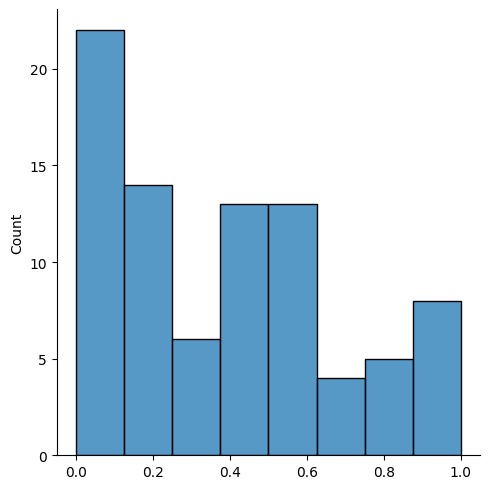

In [32]:
import seaborn as sns
sns.displot(wer)

"WER" plot is skewed to the right. And most of the time traditional WER didn't improve at all that's why we have the highest bar at '0'.

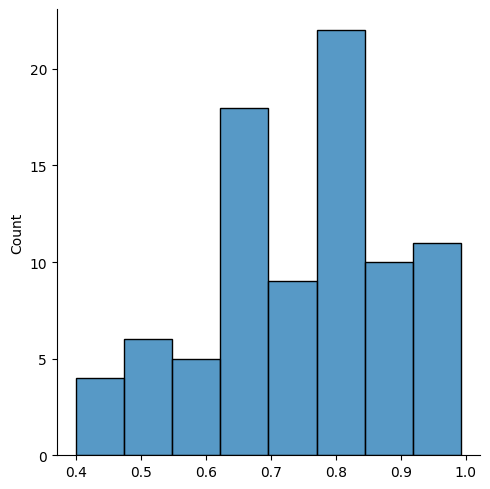

In [33]:
sns.displot(distance)

"Distance" plot is skewed to the left. But it indicates that our strings were close to ground truth with the accuracy of almost 80 % most of the time with the lowest accuracy of 40-50 % and maximum is 100 % but it is saying 99.9 for some reason over here.

# Now focusing on detection

This is checking the Levenshtein distance and WER changes before and after EEMD has been applied to perturbed audios

In [34]:
def EEMDTranscriptionDetection(x:int):
  signal = librispeech_adv_eval[x]['audio']['array']
  groundTruth = librispeech_adv_eval[x]['true_text']
  IMFs12, residue12      = appEEMD(signal)
  emps12 = 0
  for i in range(len(IMFs12)):
    emps12 += IMFs12[i]
  transcription0 = attack.INFER(torch.from_numpy(signal.reshape(1, signal.size)).float().to(device)).replace("|"," ")
  transcription2 = attack.INFER(torch.from_numpy(emps12.reshape(1, emps12.size)).float().to(device)).replace("|"," ")
  print("Transcription before any changes     : ", transcription0)
  print("Transcription after applying EEMD    : ", transcription2)
  temp = torch.from_numpy(signal.reshape(1, emps12.size)).float().to(device)
  wer = attack.wer_compute([transcription2], [temp.cpu().numpy()], targeted= True)[0]    # WER (EEMD transcription, perturbed signal) or in other words it is transcription match rate(TMR)
  distance = Levenshtein.ratio(transcription2, transcription0)                           # Levenshtein (EEMD transcription, perturbed transcription)
  print("WER                  :", (wer) * 100)
  print("Levenshtein distance :", distance * 100)
  info = attack.wer_compute([transcription2], [temp.cpu().numpy()], targeted= True)[1]
  print(f"Insertion: {info[0][1]}, Substitution: {info[0][0]}, Deletion: {info[0][2]}")
  print("-"*150)
  print("Ground Truth is                      : ", "".join(groundTruth))
  return wer, distance

In [35]:
werDetect = []
distanceDetect = []
for i in range(85):
  print("*"*150)
  print("-"*150)
  print("*"*150)
  print(str(str(i)+" ITERATION").center(140))
  print("*"*150)
  print("-"*150)
  print("*"*150)
  out = EEMDTranscriptionDetection(i)
  werDetect.append(out[0])
  distanceDetect.append(out[1])

******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                0 ITERATION                                                                 
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
********************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


Transcription before any changes     :  N WHATS LARS FOR SHE'S ON LIKE FIVE AND TWENTY 
Transcription after applying EEMD    :  AN WHAT SORT OF ESMO CAVE LIKE APONTMATI 
WER                  : 9.999999999999998
Levenshtein distance : 56.81818181818181
Insertion: 1, Substitution: 8, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  AND WHAT SORT OF EVIDENCE IS LOGICALLY POSSIBLE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
             

EEMD: 100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


Transcription before any changes     :  TIS A LETTER IN KANGY AND I AM VERY SORRY FOR IT BUT I'LL SWEAR I KNOW NOT HOW TO HELP IT 
Transcription after applying EEMD    :  REMEMBERING HASE TO BE A PIPE UP WITH HURRY AN SOME WAY WITH IT WHEN A HOS WAY WOULD DO WHAT I OO IT 
WER                  : 0.0
Levenshtein distance : 43.97905759162304
Insertion: 0, Substitution: 22, Deletion: 3
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  REMEMBERING HAS TO BE A PRESENT OCCURRENCE IN SOME WAY RESEMBLING OR RELATED TO WHAT IS REMEMBERED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***********************

EEMD: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it]


Transcription before any changes     :  NORI DIARCE  SHET'S ONLY FIVE AND TWENTY 
Transcription after applying EEMD    :  BUT I DO NOT THINK SUCH MA Y QUANTY 
WER                  : 0.0
Levenshtein distance : 38.961038961038966
Insertion: 0, Substitution: 7, Deletion: 3
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  BUT I DO NOT THINK SUCH AN INFERENCE IS WARRANTED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                   

EEMD: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


Transcription before any changes     :  NO YEARS FOR SHE'S ONLY FIVLE AND TWETTY 
Transcription after applying EEMD    :  FAMILIARITY WITH A FELLY CAPABLE EPIGY 
WER                  : 0.0
Levenshtein distance : 35.0
Insertion: 1, Substitution: 7, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  FAMILIARITY IS A FEELING CAPABLE OF DEGREES
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                    

EEMD: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it]


Transcription before any changes     :  TAKE THE MET OF WHAT LEGI CRAE SCRAPING OUT ALL OF THE FATRAM THE TEL 
Transcription after applying EEMD    :  IN THIS CASE AS IN MOST OTHERS WHAT MAY BE TAKEN ASKIRTENT ON THANT IS RATHER THOUGH 
WER                  : 0.0
Levenshtein distance : 50.32258064516129
Insertion: 0, Substitution: 15, Deletion: 3
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  IN THIS CASE AS IN MOST OTHERS WHAT MAY BE TAKEN AS CERTAIN IN ADVANCE IS RATHER VAGUE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***********************************************************************

EEMD: 100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


Transcription before any changes     :  TAKE THE POT OF UNLAYRD GRBATSCRIN UTOLD HEOF THE FETRO MA THU  HELL 
Transcription after applying EEMD    :  THE FIRST OF OUR VAGUE ATOUT INDUBITABLE DATA THE FECTER OF KNOWLEDGE OF THE TALS 
WER                  : 6.25
Levenshtein distance : 50.331125827814574
Insertion: 0, Substitution: 12, Deletion: 3
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THE FIRST OF OUR VAGUE BUT INDUBITABLE DATA IS THAT THERE IS KNOWLEDGE OF THE PAST
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*****************************************************************************

EEMD: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


Transcription before any changes     :  LET ME SAY HO FAIN IT REGINS 
Transcription after applying EEMD    :  A FAIT OF FATE IS RECOGNITION 
WER                  : 0.0
Levenshtein distance : 54.23728813559322
Insertion: 0, Substitution: 7, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  A FURTHER STAGE IS RECOGNITION
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                7 ITERATI

EEMD: 100%|██████████| 20/20 [00:36<00:00,  1.82s/it]


Transcription before any changes     :  SYCA THE MEIT OF ONE CLERGE CRAB SCREP OUT ALL OF THE APHETO FROM THE OAS HELL 
Transcription after applying EEMD    :  SOMETINAT T MADI TOPENE TERG TRAB STECKOUT ANY THEORY A FATO FROM AS ARIVAL 
WER                  : 0.0
Levenshtein distance : 59.354838709677416
Insertion: 2, Substitution: 15, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  SOME POINTS MAY BE TAKEN AS FIXED AND SUCH AS ANY THEORY OF MEMORY MUST ARRIVE AT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***************************************************************************

EEMD: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


Transcription before any changes     :  AT IS LOLAS THE LINLY AND LIEUTENANT COULD BEAR THE ANXITY NO LONGER 
Transcription after applying EEMD    :  IT IS KNOWLEDGE A MEMORY IN ONE THING THOUGH IN ANOTHER ITTNOL 
WER                  : 7.692307692307687
Levenshtein distance : 50.0
Insertion: 0, Substitution: 12, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THIS KNOWLEDGE IS MEMORY IN ONE SENSE THOUGH IN ANOTHER IT IS NOT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:33<00:00,  1.67s/it]


Transcription before any changes     :  TAKE SOME IMITATE OF ONE LIGAND CRAME SCRAPIONG UT ALSO THE MILATE FROM OTHER  SHELL 
Transcription after applying EEMD    :  SOME IMITATES LIKE SONSENSATION TOUG VERY FAMILIAR WHILE OTHERS FIL CHANGE 
WER                  : 0.0
Levenshtein distance : 56.25
Insertion: 3, Substitution: 12, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  SOME IMAGES LIKE SOME SENSATIONS FEEL VERY FAMILIAR WHILE OTHERS FEEL STRANGE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***************************************************************************************

EEMD: 100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


Transcription before any changes     :  WHAT OF TES NOT A MAN UNDERGO FOR THE SAKE OF ACURE 
Transcription after applying EEMD    :  BUT IT VEX THAT A TEGENTRAL SETHEORY OF KNOWLEDGE 
WER                  : 8.333333333333337
Levenshtein distance : 45.09803921568627
Insertion: 2, Substitution: 9, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  IT IS THIS THAT IS OF INTEREST TO THEORY OF KNOWLEDGE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
************************************************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:22<00:00,  1.10s/it]


Transcription before any changes     :  TAGGY THE MEAT OF UDEE LARGE CRAGE SCRAPPING OUT ALL OF THE FATERPLACE SHELL 
Transcription after applying EEMD    :  I GAVE THE SPEAT OF EVERYDAY LARGE FOR GOOD CARRYING UT ON THE TONE OF APROPLATION 
WER                  : 0.0
Levenshtein distance : 58.75
Insertion: 0, Substitution: 14, Deletion: 3
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  AS USED IN THE SPEECH OF EVERYDAY LIFE THE WORD CARRIES AN UNDERTONE OF DEPRECATION
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*********************************************************************************

EEMD: 100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


Transcription before any changes     :  TO SAY THERE IN CHANGES AN I AM VERY SORRY FOR IT BUT I ILL SWEAR I KNOW NOT HOW TO HELP IT 
Transcription after applying EEMD    :  TO SAY THEIR CHANGES OF THIS GABARITORY CER DOMESTIC SPETER AVE ALREADY BE INDECATED 
WER                  : 8.695652173913048
Levenshtein distance : 50.847457627118644
Insertion: 8, Substitution: 13, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THE SALIENT FEATURES OF THIS DEVELOPMENT OF DOMESTIC SERVICE HAVE ALREADY BEEN INDICATED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
********************************

EEMD: 100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


Transcription before any changes     :  TAKE THE GIMMAL WAY ONO ON LARDE GRAB GRAPING OU HE OVE THE FAT FROM THE SHELL 
Transcription after applying EEMD    :  IN A GENERAL WAY THOUGH NOT ONLY N OR CONFRICTION FOTE TO THE FREE FROM THE SHA 
WER                  : 22.22222222222222
Levenshtein distance : 59.11949685534591
Insertion: 0, Substitution: 13, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  IN A GENERAL WAY THOUGH NOT WHOLLY NOR CONSISTENTLY THESE TWO GROUPS COINCIDE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
**************************************************************

EEMD: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


Transcription before any changes     :  TAKE THE METON SLAR GRABS GREOPING OUT ALL OF THE EARNE FATE FROM THE SHELL 
Transcription after applying EEMD    :  EACH WEL TER FA CLER ABOUT IPING OUTI OF THE EARLIEST FATL OF THE SHAVEL 
WER                  : 18.75
Levenshtein distance : 65.7718120805369
Insertion: 0, Substitution: 12, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  EACH WILL THEREFORE SERVE ABOUT EQUALLY WELL DURING THE EARLIER STAGES OF SOCIAL GROWTH
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***************************************************************************

EEMD: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


Transcription before any changes     :  IS A THRE GENGLE AND I AM VERY SORRY FOR IT BUT I'LL FOUND I KNOW NOT IALL TO HELP I 
Transcription after applying EEMD    :  IN THE COMMUNITY O YE WIT CIMPERTORY FORINT WIT HIG AND FOUNDIN ON THE LOAD OF A PIE 
WER                  : 0.0
Levenshtein distance : 54.117647058823536
Insertion: 2, Substitution: 19, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  IN THE COMMUNITIES OF THE WESTERN CULTURE THIS POINT IS AT PRESENT FOUND AMONG THE LOWER MIDDLE CLASS
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
****************************************

EEMD: 100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


Transcription before any changes     :  TIE SOSTRING A CANTENAGE AND I AM VERY SORRY FOR IT BUT ELSEWHERE I KNOW NOT HOW TO HELP IT 
Transcription after applying EEMD    :  TOM SOMSING TOCOME TO LODGE I AN AM VERY SOUNDRRY OF HIBBEN AN WE PI KNOW NOT AT COMECTED 
WER                  : 5.000000000000004
Levenshtein distance : 60.439560439560445
Insertion: 0, Substitution: 19, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  CONSUMPTION BECOMES A LARGER ELEMENT IN THE STANDARD OF LIVING IN THE CITY THAN IN THE COUNTRY
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*********************

EEMD: 100%|██████████| 20/20 [00:37<00:00,  1.87s/it]


Transcription before any changes     :  THE BURGIS IT WOT CARE MUCH ABOUT BEING BURIAD IN THE FAGIRAD IT HIGHTED AT POVERTY WHER PLECASISA IF YOU PLEASE 
Transcription after applying EEMD    :  THE BETWIS WHIC CARETUM OT  EXVERIENCE IT TE OGERRGE IT PINT I IT CONVERTY FAR AKE ASISIDE IF YOU PLEASE 
WER                  : 18.181818181818176
Levenshtein distance : 62.38532110091744
Insertion: 0, Substitution: 17, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THE QUESTION IS WHICH OF THE TWO METHODS WILL MOST EFFECTIVELY REACH THE PERSONS WHOSE CONVICTIONS IT IS DESIRED TO AFFECT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------

EEMD: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


Transcription before any changes     :  TAKE THE MUDOFOGANELE A CABLES GRAFINGERI OF THE VADRAN EZELL 
Transcription after applying EEMD    :  THE MUD AN ORGANIZATION OF INDUSTORY WAS FROM THE FAIN DIRECTION OF THE VALU OF E LEN 
WER                  : 0.0
Levenshtein distance : 48.64864864864865
Insertion: 0, Substitution: 10, Deletion: 8
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THE MODERN ORGANIZATION OF INDUSTRY WORKS IN THE SAME DIRECTION ALSO BY ANOTHER LINE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
********************************************************************************

EEMD: 100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Transcription before any changes     :  TIS A STRANGE CHANGE AND I AM VERY SORRY VERTED BUT I'LL SWEAR I KNOW NOT HOW TO HELP IS 
Transcription after applying EEMD    :  TIS APRENTIATION LIKE FERGATS BY BE INHERITED BETHWELT AND RECONSEQUENT ON HOW TO HELP ATEISM 
WER                  : 5.000000000000004
Levenshtein distance : 53.551912568306
Insertion: 4, Substitution: 15, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THIS DIFFERENTIATION IS FURTHERED BY THE INHERITANCE OF WEALTH AND THE CONSEQUENT INHERITANCE OF GENTILITY
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***********

EEMD: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


Transcription before any changes     :  THE LITEALY FRON TE NAND ALBIARE THE ANXIETY NO LANGER 
Transcription after applying EEMD    :  THE LIBERY BECOME ABNUPTOVE TO MAY OR BEARLY QUIETUARI 
WER                  : 9.999999999999998
Levenshtein distance : 49.09090909090909
Insertion: 0, Substitution: 9, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THE LIVERY BECOMES OBNOXIOUS TO NEARLY ALL WHO ARE REQUIRED TO WEAR IT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***********************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:20<00:00,  1.05s/it]


Transcription before any changes     :  AT LEFT THE GLITTLE LIEUTENANT NO CUL MOT THE ANGETE NO LONGER 
Transcription after applying EEMD    :  LET THE GENERAL HIS GILTON IS NOT FROM MATICOWN TO BE OVEMOVED 
WER                  : 0.0
Levenshtein distance : 49.20634920634921
Insertion: 0, Substitution: 12, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  BUT THE GENERAL DISTINCTION IS NOT ON THAT ACCOUNT TO BE OVERLOOKED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***********************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it]


Transcription before any changes     :  HE IS IL STRANGE TANGE AND I AM E VERY SORRY FOR YET BUT I'LL WHERE I KNOW NOT HOW TO HELP IT 
Transcription after applying EEMD    :  THE ATILITY AF CONFUNTION I CAN EVIDATE OF WEALTH IS BU THE CLASS WHERE A JURY BETER GROWT 
WER                  : 0.0
Levenshtein distance : 48.64864864864865
Insertion: 4, Substitution: 19, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THE UTILITY OF CONSUMPTION AS AN EVIDENCE OF WEALTH IS TO BE CLASSED AS A DERIVATIVE GROWTH
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
************************************

EEMD: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


Transcription before any changes     :  IT IS VELLE ENOUGH ELABORETH THE CHENYOU WELL CARRY HER OUT 
Transcription after applying EEMD    :  IT WAS NO ENOUGH ELABORATE TIGENERAL RICAN GREAT 
WER                  : 18.181818181818176
Levenshtein distance : 60.55045871559632
Insertion: 2, Substitution: 7, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THERE IS A MORE OR LESS ELABORATE SYSTEM OF RANK AND GRADES
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
**********************************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


Transcription before any changes     :  TAKE THE MAT OF ONE LUXURY AMSCRAPING OTILE THE RANT FROM THE LEGER HELL 
Transcription after applying EEMD    :  IN THE NATURE OF THE LEXURY AND THE CONFLICTS OF LIFE THELONG OF THE LEDGEF HEATH 
WER                  : 11.764705882352944
Levenshtein distance : 59.354838709677416
Insertion: 0, Substitution: 12, Deletion: 3
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  IN THE NATURE OF THINGS LUXURIES AND THE COMFORTS OF LIFE BELONG TO THE LEISURE CLASS
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
********************************************************

EEMD: 100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


Transcription before any changes     :  TIS ASRINGOOKANGI AND I AM VERO SORRY FOR IT BUT HELLS VERY HONOTER TO HELP IT 
Transcription after applying EEMD    :  THEY DREW BACK A LITTLE FROM THE ENTRANCE AND MOTION FOR IT SUPPOSED CONJUEROR TO ENT 
WER                  : 0.0
Levenshtein distance : 46.060606060606055
Insertion: 0, Substitution: 16, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THEY DREW BACK A LITTLE FROM THE ENTRANCE AND MOTIONED TO THE SUPPOSED CONJURER TO ENTER
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
**********************************************************

EEMD: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Transcription before any changes     :  AT LAGE TUT THE FLAGGYS LIE LENANDA WELLDBE THEM ANCIENT NO LONGER 
Transcription after applying EEMD    :  THE BEAR SHUT THIS SHAGGY SIDES AND THEN A WELL KNOWN VOICE REPLIED 
WER                  : 0.0
Levenshtein distance : 53.333333333333336
Insertion: 0, Substitution: 12, Deletion: 2
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THE BEAR SHOOK HIS SHAGGY SIDES AND THEN A WELL KNOWN VOICE REPLIED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


Transcription before any changes     :  TOCRALEGU CANGANDO AESORI FA OUR FIT BUT I'LL SWEAR I KNOWS NOT O TO HELP IT 
Transcription after applying EEMD    :  WHAT SHALL WE DO WITH THE MINDOS AT TE DORI TAKEN OUT SIX AND THE SIN RITES AS GOOD AS NOTHING 
WER                  : 0.0
Levenshtein distance : 44.18604651162791
Insertion: 0, Substitution: 16, Deletion: 6
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  WHAT SHALL WE DO WITH THE MINGOES AT THE DOOR THEY COUNT SIX AND THIS SINGER IS AS GOOD AS NOTHING
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************

EEMD: 100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


Transcription before any changes     :  LET ME SEE HOW CAN IT BUNGIN 
Transcription after applying EEMD    :  LEV E HEAR HIM KIN IT BRUNGIN 
WER                  : 12.5
Levenshtein distance : 71.1864406779661
Insertion: 0, Substitution: 6, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  WILL THE HURONS HEAR HIS GROANS
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                29 ITERA

EEMD: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


Transcription before any changes     :  TELK WHAT CAN'T HAVE DONE LY NAME SCRABE HES OLL I OUT OLD NOF THY FET FROM THY SHELL 
Transcription after applying EEMD    :  WELL WHAT CAN'T BE DONE BY MAIN COURAGEING OR MUST BE DONE BY FIRCUMVENTIAL 
WER                  : 15.789473684210531
Levenshtein distance : 56.790123456790134
Insertion: 4, Substitution: 12, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  WELL WHAT CAN'T BE DONE BY MAIN COURAGE IN WAR MUST BE DONE BY CIRCUMVENTION
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
**********************************************************

EEMD: 100%|██████████| 20/20 [00:34<00:00,  1.72s/it]


Transcription before any changes     :  I HE TRANLYGENERAL CHANGE YO FOUD I AM MY VERY THORY FOR IT BUT IN LARS WERE I KNOW NOT HOW TO SURV IT 
Transcription after applying EEMD    :  BRAVELY AND GENEROUSLY AS YO BATTLED IN MY BE HALF AND THIS AND MORE WOULD I DAE IN HIS SERVICE 
WER                  : 4.1666666666666625
Levenshtein distance : 49.246231155778894
Insertion: 3, Substitution: 20, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  BRAVELY AND GENEROUSLY HAS HE BATTLED IN MY BEHALF AND THIS AND MORE WILL I DARE IN HIS SERVICE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
**

EEMD: 100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


Transcription before any changes     :  ON TIS YO TERCATE THE LEAG AND I WILL EVER LORY FOR IT BUT ILL SWELL I KNOW NOT HOW TO HELP IT 
Transcription after applying EEMD    :  SO ON THIS YOU HAD BETTER TAKE THE LEAD WORE I WILL PUT ON A SKIAN AGLAIN AND THRUST  HENIM FOR WANT OF FEELING 
WER                  : 0.0
Levenshtein distance : 54.106280193236714
Insertion: 0, Substitution: 23, Deletion: 3
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  SO UNCAS YOU HAD BETTER TAKE THE LEAD WHILE I WILL PUT ON THE SKIN AGAIN AND TRUST TO CUNNING FOR WANT OF SPEED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------

EEMD: 100%|██████████| 20/20 [00:34<00:00,  1.72s/it]


Transcription before any changes     :  TI A STRANGE CHAIRANGE MAND I GAM VERY HURRY FOR IT BOUT I'LL UTTER IN NEWN OF THES WAY TO THE CMIND 
Transcription after applying EEMD    :  TILL AS SUNING IN HIS HAIR AND MANNER GET BETRAYED FOT HI SPOUT HE UTTERED CONFUSION OF THE SWATE OF HIS MIND 
WER                  : 4.347826086956519
Levenshtein distance : 60.66350710900474
Insertion: 0, Substitution: 21, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THERE WAS SOMETHING IN HIS AIR AND MANNER THAT BETRAYED TO THE SCOUT THE UTTER CONFUSION OF THE STATE OF HIS MIND
******************************************************************************************************************************************************
-----------------------------------------------------------------------------------------------------------------------------

EEMD: 100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


Transcription before any changes     :  TIS A STRANGE CHANGE TURNED AIL AN VREASONS ORTHRE FOR IT BUT I'LL SWEAR I NOW NOT HOW TO HELP IT 
Transcription after applying EEMD    :  CAN THESE PING GANE RETURNED DAVID BREATHING MORE FREELY AS THE TRUTH TO WAN E DAWN UPON HIM 
WER                  : 0.0
Levenshtein distance : 52.35602094240838
Insertion: 2, Substitution: 19, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  CAN THESE THINGS BE RETURNED DAVID BREATHING MORE FREELY AS THE TRUTH BEGAN TO DAWN UPON HIM
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*****************************

EEMD: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Transcription before any changes     :  THE YOUNG MAN IT A LIAGE TAND NHY COULD I BEAR THE ANXIETY OF LHEGRE 
Transcription after applying EEMD    :  THE YOUNG MAN IS IN BONDAGE AND MUCH I FEAR HIS DEATH IS DECREED 
WER                  : 19.999999999999996
Levenshtein distance : 64.17910447761194
Insertion: 0, Substitution: 12, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THE YOUNG MAN IS IN BONDAGE AND MUCH I FEAR HIS DEATH IS DECREED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it]


Transcription before any changes     :  THEN A STRINGT CLADAND I AM VERY SORRY FOR IT BUT O LESS WEARS I KNOW NOT HO TO HELP IT 
Transcription after applying EEMD    :  THEN AS IF SATISFIED OF THEIR SAFETY THE SCOUT LESS HIS POSITION OF SLOWLY INTO THE PLACE 
WER                  : 4.761904761904767
Levenshtein distance : 50.56179775280899
Insertion: 3, Substitution: 17, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THEN AS IF SATISFIED OF THEIR SAFETY THE SCOUT LEFT HIS POSITION AND SLOWLY ENTERED THE PLACE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***************************

EEMD: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


Transcription before any changes     :  SAT OUSEVSNOT A MAK NORAGO FOR THE SAR OF FURI 
Transcription after applying EEMD    :  SIT USE FOR YOURSELF AND MAKE A RUSH OR SARIVERY 
WER                  : 0.0
Levenshtein distance : 50.0
Insertion: 0, Substitution: 10, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  SO CHOOSE FOR YOURSELF TO MAKE A RUSH OR TARRY HERE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                           

EEMD: 100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Transcription before any changes     :  TI SOON IS IS ISTRANG A CHANGE MAN I AM VERY SORRY FOR IT WIT ALANS WHERE I KNOW NOT WHO TO HELP IT 
Transcription after applying EEMD    :  AS SOON AS THESE DISPOSITIONS WERE MADE FER STOUT FRINTER DAVEN EN GAVING HIS PARTIN INSTRUCTION 
WER                  : 4.1666666666666625
Levenshtein distance : 46.700507614213194
Insertion: 7, Substitution: 16, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  AS SOON AS THESE DISPOSITIONS WERE MADE THE SCOUT TURNED TO DAVID AND GAVE HIM HIS PARTING INSTRUCTIONS
******************************************************************************************************************************************************
---------------------------------------------------------------------------------------------------------------------------------------------------

EEMD: 100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


Transcription before any changes     :  A DOUBLE AS THE CILDELON TORDITS ON THE ANC NO LONGEAR 
Transcription after applying EEMD    :  THE DELAWARES ARE CHILDREN OF THE TORTOISE AND THE OUC OF FUGER 
WER                  : 0.0
Levenshtein distance : 58.82352941176471
Insertion: 0, Substitution: 11, Deletion: 2
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THE DELAWARES ARE CHILDREN OF THE TORTOISE AND THEY OUTSTRIP THE DEER
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
****************************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


Transcription before any changes     :  TAKE THERE ISTEAD OF OLARGE CRAB CRAMING OUT L OF THE PHATE FROM THE SHELL 
Transcription after applying EEMD    :  TAK THE BEAR INSTEAD OF ABAYING TRAN SRAN O THE FEET OF THE FACON FROM THE JOWL 
WER                  : 0.0
Levenshtein distance : 68.38709677419355
Insertion: 0, Substitution: 15, Deletion: 3
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  BUT THE BEAR INSTEAD OF OBEYING MAINTAINED THE SEAT IT HAD TAKEN AND GROWLED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*********************************************************************************

EEMD: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Transcription before any changes     :  AT LEAST THE ASTL LIEUTENANT COUT BOARTHIAS N YELOW ORGER 
Transcription after applying EEMD    :  UNCAS TASKED HIS SKIN AND STEPPED FORTH IN HIS OWN BEAUTIFUL PROPORTIONS 
WER                  : 0.0
Levenshtein distance : 45.80152671755725
Insertion: 0, Substitution: 10, Deletion: 3
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  UNCAS CAST HIS SKIN AND STEPPED FORTH IN HIS OWN BEAUTIFUL PROPORTIONS
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:32<00:00,  1.62s/it]


Transcription before any changes     :  TIS AT TREEER AND WE ISAN A SHOR GRAVE OR ITS ILLNS WHERE I NOW NOT SIG  TO OR HELP ART 
Transcription after applying EEMD    :  YET HE ARE WE WITHIN A SHORT RANGE OF ITS BALLOONS AND NOT A SIGN OF A TRAIL HAVEE COSSE 
WER                  : 0.0
Levenshtein distance : 58.75706214689266
Insertion: 0, Substitution: 21, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  YET HERE ARE WE WITHIN A SHORT RANGE OF THE SCAROONS AND NOT A SIGN OF A TRAIL HAVE WE CROSSED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*****************************************

EEMD: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


Transcription before any changes     :  AND LTHE LITTLE WOUT HAD BEEN COLD ON BERTHE HADI SALY NO LONGER  
Transcription after applying EEMD    :  IT WOULD HAVE BEEN MORE WONDERFUL HAD HE SPOKEN WITHOUT OPINION 
WER                  : 0.0
Levenshtein distance : 50.76923076923077
Insertion: 1, Substitution: 12, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  IT WOULD HAVE BEEN MORE WONDERFUL HAD HE SPOKEN WITHOUT A BIDDING
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*********************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


Transcription before any changes     :  RIV TAT ISAS HE ENHRANGE WITH THE CHILD YOU WILL CARRY HER OUT 
Transcription after applying EEMD    :  RUN BACK ANS AS CAN BRING YOU THE SIZES YOU WILL SEME YERS TROOT 
WER                  : 0.0
Levenshtein distance : 56.25
Insertion: 0, Substitution: 13, Deletion: 2
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  RUN BACK UNCAS AND BRING ME THE SIZE OF THE SINGER'S FOOT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*******************************************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


Transcription before any changes     :  NEW GERINATION HOWESE HE'S ALL FIT UNDER TWENTY 
Transcription after applying EEMD    :  THE EXAMINATION HOWEVER RESULTED IN MODESUEBLY 
WER                  : 0.0
Levenshtein distance : 58.94736842105264
Insertion: 1, Substitution: 7, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THE EXAMINATION HOWEVER RESULTED IN NO DISCOVERY
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                   

EEMD: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it]


Transcription before any changes     :  TASA OSTRU HANGER CHANGENCE I AM VERY SODRY FOR IT BAUTILSWEAR I KNOW NOT HOW TO HELP IT 
Transcription after applying EEMD    :  A CIRCLE OF A FEW HUNDRED FEET IN CIRCUMVERANCE WAS DRAW AN MUTULOUS PARTY TOOK A SEGNUL FOTIS PORTAN 
WER                  : 0.0
Levenshtein distance : 42.93193717277487
Insertion: 0, Substitution: 18, Deletion: 2
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  A CIRCLE OF A FEW HUNDRED FEET IN CIRCUMFERENCE WAS DRAWN AND EACH OF THE PARTY TOOK A SEGMENT FOR HIS PORTION
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***********

EEMD: 100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


Transcription before any changes     :  AN LET US RETRACE OUR SUT AND COULD EXAMINE AS LE KNOW LUFINGERA 
Transcription after applying EEMD    :  LET US RETRACE OUR STEPS AND EXAMINE AS WE GO WITH KEENER EYES 
WER                  : 0.0
Levenshtein distance : 71.875
Insertion: 0, Substitution: 13, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  LET US RETRACE OUR STEPS AND EXAMINE AS WE GO WITH KEENER EYES
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*************************************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


Transcription before any changes     :  A TOLS UY STROND CHANGE AND LAM YOUR UCRY FOR I ABOUT ILL SWHERE I KNOW NOT HO TO HILBINT 
Transcription after applying EEMD    :  THE WHOLE TODY FRADICATEED SCOB WERE UNPRESS POINTED OUT THE INSQUEATION OF A KNOCKASWHOM  WAS TO LIVE HIM 
WER                  : 0.0
Levenshtein distance : 44.67005076142132
Insertion: 0, Substitution: 20, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THE WHOLE PARTY CROWDED TO THE SPOT WHERE UNCAS POINTED OUT THE IMPRESSION OF A MOCCASIN IN THE MOIST ALLUVION
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*****

EEMD: 100%|██████████| 20/20 [00:36<00:00,  1.83s/it]


Transcription before any changes     :  TIS RASTRIN I ONGET AND I AM VERY SORRY FOR A VATIATILL FORO HAR TO HELP NYIT 
Transcription after applying EEMD    :  DISTRUSTING HIS OWN JUDGMENT HIS APPEALS TO THE OPINION OF CHINGECH WOT WERE FREQUENT AND EARNEST 
WER                  : 0.0
Levenshtein distance : 44.31818181818182
Insertion: 0, Substitution: 17, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  DISTRUSTING HIS OWN JUDGMENT HIS APPEALS TO THE OPINION OF CHINGACHGOOK WERE FREQUENT AND EARNEST
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***************************************

EEMD: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Transcription before any changes     :  CHIGDA HAD OFFED ON LORGE CRAB O SHRAPING OTALLE OF THE FAT FROM THE SHEEL 
Transcription after applying EEMD    :  CHINGGUTCHGUF HAD CAUGHT THE LORDE AND MOTIONING WITH HIS HAND HEBEYED HIM A SKEL 
WER                  : 6.666666666666665
Levenshtein distance : 45.85987261146497
Insertion: 0, Substitution: 14, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  CHINGACHGOOK HAD CAUGHT THE LOOK AND MOTIONING WITH HIS HAND HE BADE HIM SPEAK
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***************************************************************

EEMD: 100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


Transcription before any changes     :  HE HAD CARSE THE LITTLE LITENANT GOD BEAR THE ANXIETE NO LONGER 
Transcription after applying EEMD    :  IN FIRSE WELCOM AVOID MON GODBER THE HAVIN IS WAY FOR YEAR 
WER                  : 0.0
Levenshtein distance : 50.40650406504066
Insertion: 0, Substitution: 12, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  IN PERSON WELCOME ABOARD PROFESSOR YOUR CABIN IS WAITING FOR YOU
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*****************************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:20<00:00,  1.05s/it]


Transcription before any changes     :  IT IS ASY ENOUGH WITH TER AND YI WILL CORRY HER OUT 
Transcription after applying EEMD    :  BE WED HERE THERE AND EVERYWHERE IN PERFECT CORTEMTMENT 
WER                  : 0.0
Levenshtein distance : 42.592592592592595
Insertion: 2, Substitution: 10, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  HE WENT HERE THERE AND EVERYWHERE IN PERFECT CONTENTMENT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***************************************************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


Transcription before any changes     :  SOT YO OW DURNING TO GRAVE DEGAR TEN 
Transcription after applying EEMD    :  BUT NOW NOTHING CAN RAVE ME BACK 
WER                  : 0.0
Levenshtein distance : 54.28571428571429
Insertion: 0, Substitution: 8, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  BUT NOW NOTHING COULD HOLD ME BACK
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                          

EEMD: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


Transcription before any changes     :  TARKAG ETCH MATE OF NEELING A GRAPE TRAPPING OU T E OF THE FATE IRUM THE THOL 
Transcription after applying EEMD    :  OUR BAG AGE MOST IMMEDIATE RY CARIGS WOT THE DEATH OF THE FIGUTE I RUSHED AFORARD 
WER                  : 0.0
Levenshtein distance : 55.00000000000001
Insertion: 0, Substitution: 17, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  OUR BAGGAGE WAS IMMEDIATELY CARRIED TO THE DECK OF THE FRIGATE I RUSHED ABOARD
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
**************************************************************************

EEMD: 100%|██████████| 20/20 [00:32<00:00,  1.60s/it]


Transcription before any changes     :  TAKE THE ODI OF ONE LARGE SACKRED VOWING OTHRAL OF THREECH E FIR FRO M THE SHELL 
Transcription after applying EEMD    :  DEPARTING FROM FIVE HUNDRED THOUSAND THROTS THREE CHEERS FIRST FRORIT MBESHA 
WER                  : 0.0
Levenshtein distance : 54.43037974683544
Insertion: 5, Substitution: 12, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  DEPARTING FROM FIVE HUNDRED THOUSAND THROATS THREE CHEERS BURST FORTH IN SUCCESSION
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***********************************************************************

EEMD: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


Transcription before any changes     :  LIT ARE SEE HOW CAN IS BARGAINS 
Transcription after applying EEMD    :  I ASK HERCANDE BEGAIN 
WER                  : 0.0
Levenshtein distance : 59.25925925925925
Insertion: 2, Substitution: 5, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  I ASKED FOR COMMANDER FARRAGUT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                56 ITERATION  

EEMD: 100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


Transcription before any changes     :  TEY THE TOUAESTA TI OF ARGICONSCIRENING OTSAL OF THEIR FATE FROM THE SEM 
Transcription after applying EEMD    :  EVEN THOU I MAYJEST RETURN FROM AN ARDUCOUS SKERNING EXHAUSTED AND VARIFECTME THE ARES 
WER                  : 0.0
Levenshtein distance : 51.24999999999999
Insertion: 0, Substitution: 13, Deletion: 2
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  EVEN SO I HAD JUST RETURNED FROM AN ARDUOUS JOURNEY EXHAUSTED AND BADLY NEEDING A REST
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************

EEMD: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


Transcription before any changes     :  ET AS HOW LITTLE LEVIN STRUCTAND COULD SEP BARREW THE NAGELY NO LONGER 
Transcription after applying EEMD    :  ANYHOW WE'LL LEVE INSTRUCTIONS TO SHIP BEALD THENASURY TO FRANC 
WER                  : 0.0
Levenshtein distance : 59.25925925925925
Insertion: 2, Substitution: 11, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  ANYHOW WE'LL LEAVE INSTRUCTIONS TO SHIP THE WHOLE MENAGERIE TO FRANCE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


Transcription before any changes     :  NOTE HIGOUS FOR YER ONLY FIVE  TWENTY 
Transcription after applying EEMD    :  WE'LL BE QUITE COMFORTABLE HERE I CALLED CONTBETDY 
WER                  : 0.0
Levenshtein distance : 42.69662921348315
Insertion: 0, Substitution: 7, Deletion: 2
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  WE'LL BE QUITE COMFORTABLE HERE I TOLD CONSEIL
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                           

EEMD: 100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


Transcription before any changes     :  ATELY LEST THE LITTLE ISSUE OF TENANT COULD WEAR THE MANTARIADY NO LONGER 
Transcription after applying EEMD    :  ITLE MY FRIEND ITTLE ISSUE OF THE NON THE NOTORIAS NORLAN 
WER                  : 15.384615384615385
Levenshtein distance : 62.121212121212125
Insertion: 1, Substitution: 10, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  YOU SEE MY FRIEND IT'S AN ISSUE OF THE MONSTER THE NOTORIOUS NARWHALE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***********************************************************************************************

EEMD: 100%|██████████| 20/20 [00:33<00:00,  1.68s/it]


Transcription before any changes     :  TAES OU STRANGE CHUNGE AND I SHAN BE LIK A FRAD FOR A BUT INAL A SPIART I KNOW NOT HOW TO HELP IT 
Transcription after applying EEMD    :  I LEFT INSTRUCTIONS FOR SHIPPING MY COMPANIONS FOR STUFFED ANIMALS AND STRARKED MY UNTE PARIS FRENDS 
WER                  : 0.0
Levenshtein distance : 39.19597989949749
Insertion: 7, Substitution: 17, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  I LEFT INSTRUCTIONS FOR SHIPPING MY CONTAINERS OF STUFFED ANIMALS AND DRIED PLANTS TO PARIS FRANCE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***************

EEMD: 100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


Transcription before any changes     :  NOT E  FOR SHA'S ON LI FAVE AND TUINTY 
Transcription after applying EEMD    :  MAFE AT OREFER TAN PAFE A PERNT 
WER                  : 0.0
Levenshtein distance : 47.887323943661976
Insertion: 1, Substitution: 8, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  CONSEIL I CALLED A THIRD TIME CONSEIL APPEARED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                            

EEMD: 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


Transcription before any changes     :  LET ME ASK HORACAN ILBAGUEN 
Transcription after applying EEMD    :  AND YET PUT A FINE GALA LAND 
WER                  : 0.0
Levenshtein distance : 45.614035087719294
Insertion: 0, Substitution: 5, Deletion: 3
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  AND YET WHAT A FINE GALLANT LAD
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                63 ITERAT

EEMD: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


Transcription before any changes     :  L HERLO CAN I BAGIN 
Transcription after applying EEMD    :  LITE GELLIPAMRA BA 
WER                  : 0.0
Levenshtein distance : 46.15384615384615
Insertion: 1, Substitution: 4, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  WE'LL DEAL WITH THEM LATER WHAT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                64 ITERATION                

EEMD: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


Transcription before any changes     :  HE HAD HARDLY THE STRENGTH TO SET AMMER 
Transcription after applying EEMD    :  HE HAD RANDED THE STRANG TO SAID AMME 
WER                  : 44.44444444444444
Levenshtein distance : 76.92307692307692
Insertion: 0, Substitution: 4, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  DID MASTER SUMMON ME HE SAID ENTERING
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                 

EEMD: 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


Transcription before any changes     :  WHAT COUND THIS MAE SHE SAID TO HERSELF 
Transcription after applying EEMD    :  A GROUND THIS MIGHTLY REST OU THAT TASELF 
WER                  : 11.111111111111116
Levenshtein distance : 60.97560975609756
Insertion: 0, Substitution: 7, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  A ROUTE SLIGHTLY LESS DIRECT THAT'S ALL
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                          

EEMD: 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Transcription before any changes     :  NOT AT ME MAN FER SHE'S ONLY FN TWENTY 
Transcription after applying EEMD    :  YOU HAVE A COMMANDER HES GAME FOR ANYPANTI 
WER                  : 0.0
Levenshtein distance : 51.21951219512195
Insertion: 0, Substitution: 9, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  WE HAVE A COMMANDER WHO'S GAME FOR ANYTHING
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                     

EEMD: 100%|██████████| 20/20 [00:32<00:00,  1.62s/it]


Transcription before any changes     :  YEAT LAST A DHELIGHT A LIE LIEUTENANT COULD BUT HAVE THE ANXIETY NO LONGER 
Transcription after applying EEMD    :  YET WE ARE CERTAINLY I REPLY TE ATECID BUT AFTER WE WITE A NUTOLER 
WER                  : 6.666666666666665
Levenshtein distance : 54.92957746478873
Insertion: 0, Substitution: 13, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  YES WE ARE CERTAINLY I REPLIED EVASIVELY BUT AFTER WE MAKE A DETOUR
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*****************************************************************************************

EEMD: 100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Transcription before any changes     :  SO ON'T NO REREOTARY THING 
Transcription after applying EEMD    :  WE DON'T KNOW WHERE WOR A TIN 
WER                  : 0.0
Levenshtein distance : 66.66666666666667
Insertion: 0, Substitution: 5, Deletion: 3
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  WE DON'T KNOW WHERE IT WILL TAKE US
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                69 ITE

EEMD: 100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


Transcription before any changes     :  LET ME SEW HOW CAN IT BEGAN 
Transcription after applying EEMD    :  LET MY GOIN AS BEGAN 
WER                  : 14.28571428571429
Levenshtein distance : 65.3061224489796
Insertion: 1, Substitution: 5, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  BUT WE'RE GOING JUST THE SAME
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                70 ITER

EEMD: 100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


Transcription before any changes     :  TAKE A THE MEAD OF ONE LARGE CRAY WIT THE SCRAPING OUT ALL OF THE FAT FRONDYSHELL 
Transcription after applying EEMD    :  TAKE TO GIVE TE ETIF UNDERNIRDE GRAVE OF THE DRIPPING WHAT I HAVE TA FORITY 
WER                  : 5.882352941176472
Levenshtein distance : 54.43037974683544
Insertion: 1, Substitution: 15, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  PLEASE FORGIVE ME FOR THIS UNDERHANDED WAY OF ADMITTING I HAD TURNED FORTY
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************

EEMD: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


Transcription before any changes     :  OUTLIS THE LITALIET AND UNCOLED BOUTHE HUNGIATILOLUGARIA 
Transcription after applying EEMD    :  OUT ONCE THE HUCAMIA TOMANTO LANK BY THE HARDSHIPS OF LAGARNIA 
WER                  : 0.0
Levenshtein distance : 53.333333333333336
Insertion: 0, Substitution: 7, Deletion: 5
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  NOT ONCE DID HE COMMENT ON THE LENGTH OR THE HARDSHIPS OF A JOURNEY
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*****************************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Transcription before any changes     :  LET ME SEE HOW CAN I BEVISION 
Transcription after applying EEMD    :  CHAPTER THREE HOUSENAS DIVISIONS 
WER                  : 0.0
Levenshtein distance : 57.14285714285714
Insertion: 2, Substitution: 5, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  CHAPTER THREE AS MASTER WISHES
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                73 IT

EEMD: 100%|██████████| 20/20 [00:31<00:00,  1.59s/it]


Transcription before any changes     :  TELL IS GED OF ES THAN PRESCRIB IN ING EALLY OF THE WORLD FROM  THE MOSH LAND 
Transcription after applying EEMD    :  THERE WAS GOOD REASON FOR SCRIPING THING EVEN FOR THE WORLD'S MOST DEMOTIONLESS MAN 
WER                  : 0.0
Levenshtein distance : 59.25925925925925
Insertion: 2, Substitution: 15, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THERE WAS GOOD REASON TO STOP AND THINK EVEN FOR THE WORLD'S MOST EMOTIONLESS MAN
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*********************************************************************

EEMD: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Transcription before any changes     :  SRE LEAVING ON A ABRAHAM DADEN 
Transcription after applying EEMD    :  RELIEVING ON THE ABRAHAM LANCOLN 
WER                  : 0.0
Levenshtein distance : 75.0
Insertion: 0, Substitution: 6, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  WE'RE LEAVING ON THE ABRAHAM LINCOLN
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                75 ITERATIO

EEMD: 100%|██████████| 20/20 [00:35<00:00,  1.78s/it]


Transcription before any changes     :  TI ASTRA CHANGE AND E AM I AVERY SORRY FOR EA IT ILL SWEAR I OKEN TO INTO THE ARM TO HILP IT 
Transcription after applying EEMD    :  I WAS TWELL CHATISHED BY THE COW CAVERNS THAT WESVOCATED IN THE STERN AND OPENED INTO THE ALTATIV'S MEST 
WER                  : 0.0
Levenshtein distance : 52.52525252525253
Insertion: 3, Substitution: 20, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  I WAS WELL SATISFIED WITH MY CABIN WHICH WAS LOCATED IN THE STERN AND OPENED INTO THE OFFICERS MESS
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***************

EEMD: 100%|██████████| 20/20 [00:39<00:00,  1.98s/it]


Transcription before any changes     :  TIOSTAN GIRCLAN AND EVERY TOR HR FOR IT BUT ILL SWER IT PROUD ANY HOW TO HIEP IT 
Transcription after applying EEMD    :  THE WARVS AN BIRKLYN AND IN EVERY PART OF NEW YORK QARTERING THE EST WIVER WITH CROWDED HIT CURIOSITY SEETERES 
WER                  : 0.0
Levenshtein distance : 52.08333333333333
Insertion: 0, Substitution: 18, Deletion: 3
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THE WHARVES OF BROOKLYN AND EVERY PART OF NEW YORK BORDERING THE EAST RIVER WERE CROWDED WITH CURIOSITY SEEKERS
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*********

EEMD: 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


Transcription before any changes     :  LATRAY HASHOSAN IS BEGAN 
Transcription after applying EEMD    :  MATA WAS HI LAN BERGON 
WER                  : 0.0
Levenshtein distance : 62.5
Insertion: 0, Substitution: 4, Deletion: 2
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  CONSEIL WAS MY MANSERVANT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                78 ITERATION                          

EEMD: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


Transcription before any changes     :  TANTLAKE THE MEDIT OF ONE LARGE CRAB SCRAPING OUTLE OF THE FAT FROM THE SHELL 
Transcription after applying EEMD    :  STANTILY THE MISTAKE OF UNVARNISHED PRESCRIPTION OF IS NES ANTEN THE CHELL 
WER                  : 19.999999999999996
Levenshtein distance : 61.43790849673203
Insertion: 2, Substitution: 10, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  SUBSTANTIALLY THIS WAS JACOB'S UNVARNISHED DESCRIPTION OF HIS MASTER AND MISTRESS
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***************************************************************

EEMD: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Transcription before any changes     :  WHY DOES NOT A MAN UNDERGO FOR THE SAKE OF A CURE 
Transcription after applying EEMD    :  AS YOU AS BOTH NEVER OR DONE AND THE LIKE CUNT YOU 
WER                  : 0.0
Levenshtein distance : 47.524752475247524
Insertion: 0, Substitution: 12, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  AS USUAL NOTHING WAS DONE IN THE WAY OF PUNISHMENT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
         

EEMD: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


Transcription before any changes     :  WHATEVER DO NOT A MAN UNDERYO FOR THE ELK OF ACURE 
Transcription after applying EEMD    :  I NEVER KNEW OF BUT ONE MAN WHO COULD EVER BLIEVE HIM 
WER                  : 0.0
Levenshtein distance : 43.80952380952381
Insertion: 0, Substitution: 11, Deletion: 2
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  I NEVER KNEW OF BUT ONE MAN WHO COULD EVER PLEASE HIM
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
   

EEMD: 100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


Transcription before any changes     :  AT LEST THE LITTLE LIEUTENATANT CALL ER THE ANATITE NO LONGER 
Transcription after applying EEMD    :  THIS REFLETS VEARD THE MISCHIEF SO FAR AS THE RUNNING AWAY WIS CONCERN 
WER                  : 0.0
Levenshtein distance : 45.11278195488722
Insertion: 0, Substitution: 11, Deletion: 3
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  THIS WAS WHAT DID THE MISCHIEF SO FAR AS THE RUNNING AWAY WAS CONCERNED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


Transcription before any changes     :  NOT YARIN FOR SHES ONLY FAVE AND TWENTY 
Transcription after applying EEMD    :  TUT STARTING I DIDN'T KNOW THE WAY TO COME 
WER                  : 0.0
Levenshtein distance : 43.37349397590361
Insertion: 0, Substitution: 8, Deletion: 2
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  OF STARTING I DIDN'T KNOW THE WAY TO COME
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                      

EEMD: 100%|██████████| 20/20 [00:37<00:00,  1.87s/it]


Transcription before any changes     :  TIS ESTRANE CHANGE AND I SOM ERY ARY FALORY BIT IS BATLONS WERI KNOW NOT HOW DO ELTAT 
Transcription after applying EEMD    :  AS TE VAGE AND OFFER THE NAME OF HICMASTRY BAKE OF BATANS BURIED SOMEWHAT UNDE ADVERTISEMENT 
WER                  : 5.555555555555558
Levenshtein distance : 51.39664804469274
Insertion: 1, Substitution: 16, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  AS TO HIS AGE AND ALSO THE NAME OF HIS MASTER JACOB'S STATEMENT VARIED SOMEWHAT FROM THE ADVERTISEMENT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*****************

EEMD: 100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Transcription before any changes     :  IN NODY YEARS FOR SINS ONLY FAVO AND TWENTY 
Transcription after applying EEMD    :  IT IS HARDLY ESE FARS TE FAMOR OF PANPWENY 
WER                  : 0.0
Levenshtein distance : 55.172413793103445
Insertion: 0, Substitution: 9, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                      :  IT IS HARDLY NECESSARY TO SAY MORE OF THEM HERE


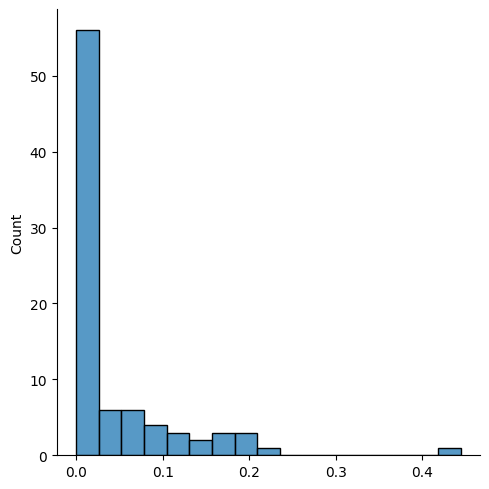

In [36]:
sns.displot(werDetect)

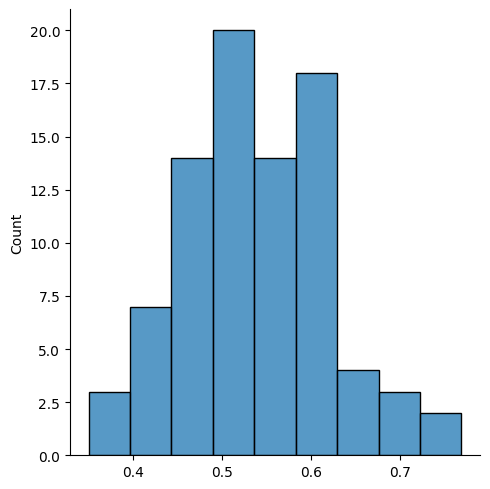

In [37]:
sns.displot(distanceDetect)

# Now checking what is the TMR of clean audios only

This is checking the Levenshtein distance and WER changes before and after EEMD has been applied to clean audios

In [38]:
def EEMDTranscriptionDetectionClean(x:int):
  signal = librispeech_clean_audios[x]['audio']['array']
  groundTruth = librispeech_clean_audios[x]['true_text']
  IMFs12, residue12      = appEEMD(signal)
  emps12 = 0
  for i in range(len(IMFs12)):
    emps12 += IMFs12[i]
  transcription0 = attack.INFER(torch.from_numpy(signal.reshape(1, signal.size)).float().to(device)).replace("|"," ")
  transcription2 = attack.INFER(torch.from_numpy(emps12.reshape(1, emps12.size)).float().to(device)).replace("|"," ")
  print("Transcription before any changes      : ", transcription0)
  print("Transcription after applying EEMD     : ", transcription2)
  temp = torch.from_numpy(signal.reshape(1, emps12.size)).float().to(device)
  wer = attack.wer_compute([transcription2], [temp.cpu().numpy()], targeted= True)[0]    # WER (EEMD transcription, clean signal) or in other words it is transcription match rate(TMR)
  distance = Levenshtein.ratio(transcription2, transcription0)                           # Levenshtein (EEMD transcription, clean audio's transcription)
  print("WER                  :", (wer) * 100)
  print("Levenshtein distance :", distance * 100)
  info = attack.wer_compute([transcription2], [temp.cpu().numpy()], targeted= True)[1]
  print(f"Insertion: {info[0][1]}, Substitution: {info[0][0]}, Deletion: {info[0][2]}")
  print("-"*150)
  print("Ground Truth is                       : ", "".join(groundTruth))
  return wer, distance

In [39]:
werDetectClean = []
distanceDetectClean = []
for i in range(85):
  print("*"*150)
  print("-"*150)
  print("*"*150)
  print(str(str(i)+" ITERATION").center(140))
  print("*"*150)
  print("-"*150)
  print("*"*150)
  out = EEMDTranscriptionDetectionClean(i)
  werDetectClean.append(out[0])
  distanceDetectClean.append(out[1])

******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                0 ITERATION                                                                 
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
********************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Transcription before any changes      :  AND WHAT SORT OF EVIDENCE IS LOGICALLY POSSIBLE 
Transcription after applying EEMD     :  AND WHAT SORT OF EVIDENCE IS LOGICALLY POSSIBLE 
WER                  : 88.88888888888889
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  AND WHAT SORT OF EVIDENCE IS LOGICALLY POSSIBLE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
              

EEMD: 100%|██████████| 20/20 [00:36<00:00,  1.84s/it]


Transcription before any changes      :  REMEMBERING HAS TO BE A PRESENT OCCURRENCE IN SOME WAY RESEMBLING OR RELATED TO WHAT IS REMEMBERED 
Transcription after applying EEMD     :  REMEMBERING HAS TO BE A PRESENT OCCURRENCE IN SOME WAY RESEMBLING OR RELATED TO WHAT IS REMEMBERED 
WER                  : 94.44444444444444
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  REMEMBERING HAS TO BE A PRESENT OCCURRENCE IN SOME WAY RESEMBLING OR RELATED TO WHAT IS REMEMBERED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
************

EEMD: 100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


Transcription before any changes      :  BUT I DO NOT THINK SUCH AN INFERENCE IS WARRANTED 
Transcription after applying EEMD     :  BUT I DO NOT THINK SUCH AN ETERENCE IS WORT 
WER                  : 72.72727272727273
Levenshtein distance : 87.2340425531915
Insertion: 0, Substitution: 2, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  BUT I DO NOT THINK SUCH AN INFERENCE IS WARRANTED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
   

EEMD: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it]


Transcription before any changes      :  FAMILIARITY IS A FILLING CAPABLE OF DEGREES 
Transcription after applying EEMD     :  FAMILIARITY IS A FEELING CAPABLE OF DEGREEKS 
WER                  : 62.5
Levenshtein distance : 94.3820224719101
Insertion: 0, Substitution: 2, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  FAMILIARITY IS A FEELING CAPABLE OF DEGREES
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                           

EEMD: 100%|██████████| 20/20 [00:36<00:00,  1.83s/it]


Transcription before any changes      :  IN THIS CASE AS IN MOST OTHERS WHAT MAY BE TAKEN AS CERTAIN IN ADVANCE IS RATHER VAGUE 
Transcription after applying EEMD     :  IN THIS CASE AS IN MOST OTHERS WHAT MAY BE TAKEN IS CERTAIN IN ADVANCE IS RATHER VAGUE 
WER                  : 89.47368421052632
Levenshtein distance : 98.85057471264368
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  IN THIS CASE AS IN MOST OTHERS WHAT MAY BE TAKEN AS CERTAIN IN ADVANCE IS RATHER VAGUE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
************************************

EEMD: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it]


Transcription before any changes      :  THE FIRST OF OUR VAGUE BUT INDUBITABLE DATA IS THAT THERE IS KNOWLEDGE OF THE PAST 
Transcription after applying EEMD     :  THE FIRST OF OUR VAGUE BUT INDUBITABLE DATA IS THAT THERE IS KNOWLEDGE OF THE PAST 
WER                  : 94.11764705882352
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  THE FIRST OF OUR VAGUE BUT INDUBITABLE DATA IS THAT THERE IS KNOWLEDGE OF THE PAST
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
************************************************************

EEMD: 100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Transcription before any changes      :  A FURTHER STAGE IS RECOGNITION 
Transcription after applying EEMD     :  A FURTHER STAGE IS RECOGNITION 
WER                  : 83.33333333333334
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  A FURTHER STAGE IS RECOGNITION
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                7

EEMD: 100%|██████████| 20/20 [00:35<00:00,  1.78s/it]


Transcription before any changes      :  SOME POINTS MAY BE TAKEN AS FIXED AND SUCH AS ANY THEORY OF MEMORY MUST ARRIVE AT 
Transcription after applying EEMD     :  SOME POINTS MAY BE TAKEN AS FIXED AND SUCH AS ANY THEORY OF MEMORY MUST ARRIVE AT 
WER                  : 94.44444444444444
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  SOME POINTS MAY BE TAKEN AS FIXED AND SUCH AS ANY THEORY OF MEMORY MUST ARRIVE AT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***************************************************************

EEMD: 100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


Transcription before any changes      :  THIS KNOWLEDGE IS MEMORY IN ONE SENSE THOUGH IN ANOTHER IT IS NOT 
Transcription after applying EEMD     :  THIS KNOWLEDGE IS MEMORY IN ONE SENSE THOUGH IN ANOTHER IT IS NOT 
WER                  : 92.85714285714286
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  THIS KNOWLEDGE IS MEMORY IN ONE SENSE THOUGH IN ANOTHER IT IS NOT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


Transcription before any changes      :  SOME IMAGES LIKE SOME SENSATIONS FEEL VERY FAMILIAR WHILE OTHERS FEEL STRANGE 
Transcription after applying EEMD     :  SOME IMAGES LIKE SOME SENSATION FEEL VERY FAMILIAR WHILE OTHERS FEEL STRANGE 
WER                  : 84.61538461538461
Levenshtein distance : 99.35483870967742
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  SOME IMAGES LIKE SOME SENSATIONS FEEL VERY FAMILIAR WHILE OTHERS FEEL STRANGE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
****************************************************************

EEMD: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


Transcription before any changes      :  IT IS THIS THAT IS OF INTEREST TO THEORY OF KNOWLEDGE 
Transcription after applying EEMD     :  IT IS THIS THAT IS A VINTEREU SUTHERY OF KNOWLEDGE 
WER                  : 45.45454545454546
Levenshtein distance : 87.61904761904762
Insertion: 0, Substitution: 6, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  IT IS THIS THAT IS OF INTEREST TO THEORY OF KNOWLEDGE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


Transcription before any changes      :  AS USED IN THE SPEECH OF EVERYDAY LIFE THE WORD CARRIES AN UNDERTONE OF DEPRECATION 
Transcription after applying EEMD     :  AS USED IN THE SPEECH OF EVERYDAY LIFE THE WORD CARRIES AN UNDERTONE OF DEPRECATION 
WER                  : 93.75
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  AS USED IN THE SPEECH OF EVERYDAY LIFE THE WORD CARRIES AN UNDERTONE OF DEPRECATION
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*********************************************************************

EEMD: 100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


Transcription before any changes      :  THE SALENT FEATURES OF THIS DEVELOPMENT OF DOMESTIC SERVICE HAVE ALREADY BEEN INDICATED 
Transcription after applying EEMD     :  THE SALENT FEATURES OF THIS DEVELOPMENT OF DOMESTIC SERVICE HAVE ALREADY BEEN INDICATED 
WER                  : 92.85714285714286
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  THE SALIENT FEATURES OF THIS DEVELOPMENT OF DOMESTIC SERVICE HAVE ALREADY BEEN INDICATED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
********************************************

EEMD: 100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


Transcription before any changes      :  IN A GENERAL WAY THOUGH NOT WHOLLY NOR CONSISTENTLY THESE TWO GROUPS COINCITE 
Transcription after applying EEMD     :  IN A GENERAL WAY THOUGH NOT WHOLLY NOR CONSISTENTLY THESE TWO GROUPS COINCIDE 
WER                  : 85.71428571428572
Levenshtein distance : 98.71794871794873
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  IN A GENERAL WAY THOUGH NOT WHOLLY NOR CONSISTENTLY THESE TWO GROUPS COINCIDE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***************************************************************

EEMD: 100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


Transcription before any changes      :  EACH WILL THEREFORE SERVE ABOUT EQUALLY WELL DURING THE EARLIER STAGES OF SOCIAL GROWTH 
Transcription after applying EEMD     :  EACH WILL THEREFORE SERVE ABOUT EQUALLY WELL DUING THE EARLIER STAGES OF SOCIAL GROWTH 
WER                  : 86.66666666666667
Levenshtein distance : 99.42857142857143
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  EACH WILL THEREFORE SERVE ABOUT EQUALLY WELL DURING THE EARLIER STAGES OF SOCIAL GROWTH
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
**********************************

EEMD: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


Transcription before any changes      :  IN THE COMMUNITIES OF THE WESTERN CULTURE THIS POINT IS AT PRESENT FOUND AMONG THE LOWER MIDDLE CLASS 
Transcription after applying EEMD     :  IN THE COMMUNITIES OF THE WESTERN CULTURE THIS POINT IS A PRESENT FOUND AMONG THE LOWER MIDDLE CLASS 
WER                  : 89.47368421052632
Levenshtein distance : 99.50738916256158
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  IN THE COMMUNITIES OF THE WESTERN CULTURE THIS POINT IS AT PRESENT FOUND AMONG THE LOWER MIDDLE CLASS
******************************************************************************************************************************************************
-----------------------------------------------------------------------------------------------------------------------------------------------

EEMD: 100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


Transcription before any changes      :  CONSUMPTION BECOMES A LARGER ELEMENT IN THE STANDARD OF LIVING IN THE CITY THAN IN THE COUNTRY 
Transcription after applying EEMD     :  CONSUMPTION BECOMES A LARGER ELEMENT IN THE STANDARD OF LIVING IN THE CITY THAN IN THE COUNTRY 
WER                  : 94.44444444444444
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  CONSUMPTION BECOMES A LARGER ELEMENT IN THE STANDARD OF LIVING IN THE CITY THAN IN THE COUNTRY
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
************************

EEMD: 100%|██████████| 20/20 [00:36<00:00,  1.81s/it]


Transcription before any changes      :  THE QUESTIONIS WHICH OF THE TWO METHODS WILL MOST EFFECTIVELY REACH THE PERSONS WHOSE CONVICTIONS IT IS DESIRED TO EFFECT 
Transcription after applying EEMD     :  THE QUESTION IS WHICH OF THE TWO METHODS WILL MOST EFFECTIVELY REACH THE PERSONS WHOSE CONVICTIONS IT IS DESIRED TO AFFECT 
WER                  : 4.545454545454541
Levenshtein distance : 98.77551020408163
Insertion: 0, Substitution: 19, Deletion: 2
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  THE QUESTION IS WHICH OF THE TWO METHODS WILL MOST EFFECTIVELY REACH THE PERSONS WHOSE CONVICTIONS IT IS DESIRED TO AFFECT
******************************************************************************************************************************************************
-------------------------------------------------------------------------------

EEMD: 100%|██████████| 20/20 [00:26<00:00,  1.30s/it]


Transcription before any changes      :  THE MODERN ORGANIZATION OF INDUSTRY WORKS IN THE SAME DIRECTION ALSO BY ANOTHER LINE 
Transcription after applying EEMD     :  THE MODERN ORGANIZATION OF INDUSTRY WORKS IN THE SAME DIRECTION ALSO BY ANOTHER LINE 
WER                  : 93.33333333333333
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  THE MODERN ORGANIZATION OF INDUSTRY WORKS IN THE SAME DIRECTION ALSO BY ANOTHER LINE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************

EEMD: 100%|██████████| 20/20 [00:31<00:00,  1.58s/it]


Transcription before any changes      :  THIS DIFFERENTIATION IS FURTHERED BY THE INHERITANCE OF WEALTH AND THE CONSEQUENT INHERITANCE OF GENTILITY 
Transcription after applying EEMD     :  THIS DEFERENTIATION IS FURTHERED BY THE INHERITANCE OF WEALTH AND THE CONSEQUENT INHERITANCE OF GENTILITY 
WER                  : 87.5
Levenshtein distance : 98.59154929577466
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  THIS DIFFERENTIATION IS FURTHERED BY THE INHERITANCE OF WEALTH AND THE CONSEQUENT INHERITANCE OF GENTILITY
******************************************************************************************************************************************************
---------------------------------------------------------------------------------------------------------------------------------------------

EEMD: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


Transcription before any changes      :  THE LIVERY BECOMES OBNOXIOUS TO NEARLY ALL WHO ARE REQUIRED TO WEAR IT 
Transcription after applying EEMD     :  THE LIVERY BECOMES OBNOXIOUS TO NEARLY ALL WHO ARE REQUIRED TO WEAR IT 
WER                  : 92.85714285714286
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  THE LIVERY BECOMES OBNOXIOUS TO NEARLY ALL WHO ARE REQUIRED TO WEAR IT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


Transcription before any changes      :  BUT THE GENERAL DISTINCTION IS NOT ON THAT ACCOUNT TO BE OVERLOOKED 
Transcription after applying EEMD     :  THAT THE GENERAL DISTINCTION IS NOT ON THAT ACCOUNT TO BE OVERLOOKED 
WER                  : 84.61538461538461
Levenshtein distance : 96.35036496350365
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  BUT THE GENERAL DISTINCTION IS NOT ON THAT ACCOUNT TO BE OVERLOOKED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
********************************************************************************************

EEMD: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


Transcription before any changes      :  THE UTILITY OF CONSUMPTION AS AN EVIDENCE OF WEALTH IS TO BE CLASSED AS A DERIVATIVE GROWTH 
Transcription after applying EEMD     :  THE UTILITY OF CONSUMPTION AS AN EVIDENCE OF WEALTH IS TO BE CLASSED AS A DERIVATIVE GROWTH 
WER                  : 94.44444444444444
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  THE UTILITY OF CONSUMPTION AS AN EVIDENCE OF WEALTH IS TO BE CLASSED AS A DERIVATIVE GROWTH
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*********************************

EEMD: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


Transcription before any changes      :  THERE IS A MORE OR LESS ELABORATE SYSTEM OF RANK AND GRATES 
Transcription after applying EEMD     :  THERE IS A MORE OR LESS ELABORATE SYSTEM OF RANK AND GRACES 
WER                  : 84.61538461538461
Levenshtein distance : 98.33333333333333
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  THERE IS A MORE OR LESS ELABORATE SYSTEM OF RANK AND GRADES
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*********************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


Transcription before any changes      :  IN THE NATURE OF THINGS LUXURIES AND THE COMFORTS OF LIFE BELONG TO THE LEISURE CLASS 
Transcription after applying EEMD     :  IN THE NATURE OF THINGS LUXURIES AND THE COMFORTS OF LIFE BELONG TO THE LEISURE CLASS 
WER                  : 94.11764705882352
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  IN THE NATURE OF THINGS LUXURIES AND THE COMFORTS OF LIFE BELONG TO THE LEISURE CLASS
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***************************************************

EEMD: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


Transcription before any changes      :  THEY DREW BACK A LITTLE FROM THE ENTRANCE AND MOTIONED TO THE SUPPOSED CONJUROR TO ENTER 
Transcription after applying EEMD     :  THEY DREW BACK A LITTLE FROM THE ENTRANCE AND MOTIONED TO THE SUPPOSED CONJUROR TO ENTER 
WER                  : 94.11764705882352
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  THEY DREW BACK A LITTLE FROM THE ENTRANCE AND MOTIONED TO THE SUPPOSED CONJURER TO ENTER
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************

EEMD: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


Transcription before any changes      :  THE BEAR SHOOK HIS SHAGGY SIDES AND THEN A WELL KNOWN VOICE REPLIED 
Transcription after applying EEMD     :  THE BEAR SHOOK HIS SHAGGY SIDES AND THEN A WELL KNOWN VOICE REPLIED 
WER                  : 92.85714285714286
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  THE BEAR SHOOK HIS SHAGGY SIDES AND THEN A WELL KNOWN VOICE REPLIED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*********************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:31<00:00,  1.58s/it]


Transcription before any changes      :  WHAT SHALL WE DO WITH THE MINGOES AT THE DOOR THEY COUNT SIX AND THE SINGER IS AS GOOD AS NOTHING 
Transcription after applying EEMD     :  WHAT SHALL WE DO WITH THE MINGOES AT THE DOOR THEY COUNT SIX AND THE SINGER IS AS GOOD AS NOTHING 
WER                  : 95.45454545454545
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  WHAT SHALL WE DO WITH THE MINGOES AT THE DOOR THEY COUNT SIX AND THIS SINGER IS AS GOOD AS NOTHING
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
**************

EEMD: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


Transcription before any changes      :  WILL THE HURANS HEAR HIS GROANS 
Transcription after applying EEMD     :  WILL THE HURONS HEAR HIS GROANS 
WER                  : 71.42857142857143
Levenshtein distance : 96.875
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  WILL THE HURONS HEAR HIS GROANS
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                             

EEMD: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


Transcription before any changes      :  WELL WHAT CAN'T BE DONE BY MAIN COURAGE AND WAR MUST BE DONE BY CIRCUMVENTION 
Transcription after applying EEMD     :  WELL WHAT CAN'T BE DONE BY MAIN COURAGE AND WAR MUST BE DONE BY CIRCUMVENTIONS 
WER                  : 87.5
Levenshtein distance : 99.36305732484077
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  WELL WHAT CAN'T BE DONE BY MAIN COURAGE IN WAR MUST BE DONE BY CIRCUMVENTION
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
****************************************************************************

EEMD: 100%|██████████| 20/20 [00:36<00:00,  1.84s/it]


Transcription before any changes      :  BRAVELY AND GENEROUSLY HAS HE BATTLED IN MY BEHALF AND THIS AND MORE WILL I DARE IN HIS SERVICE 
Transcription after applying EEMD     :  BRAVELY AND GENEROUSLY HAS HE BATTLED IN MY BEHALF AND THIS AND MORE WILL I DARE IN HIS SERVICE 
WER                  : 95.0
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  BRAVELY AND GENEROUSLY HAS HE BATTLED IN MY BEHALF AND THIS AND MORE WILL I DARE IN HIS SERVICE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
**********************************

EEMD: 100%|██████████| 20/20 [00:36<00:00,  1.82s/it]


Transcription before any changes      :  SO UNCAS YOU HAD BETTER TAKE THE LEAD WHILE I WILL PUT ON THE SKIN AGAIN AND TRUST TO CUNNING FOR WANT OF SPEED 
Transcription after applying EEMD     :  SO UNCAS YOU HAD BETTER TAKE THE LEAD WHILE I WILL PUT ON THE SKIN AGAIN AND TRUST TO CUNNING FOR WANT OF SPEED 
WER                  : 96.0
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  SO UNCAS YOU HAD BETTER TAKE THE LEAD WHILE I WILL PUT ON THE SKIN AGAIN AND TRUST TO CUNNING FOR WANT OF SPEED
******************************************************************************************************************************************************
-----------------------------------------------------------------------------------------------------------------------------------------

EEMD: 100%|██████████| 20/20 [00:34<00:00,  1.73s/it]


Transcription before any changes      :  THERE WAS SOMETHING IN HIS AIR AND MANNER THAT BETRAYED TO THE SCOUT THE UTTER CONFUSION OF THE STATE OF HIS MIND 
Transcription after applying EEMD     :  THERE WAS SOMETHING IN HIS AIR AND MANNER THAT BETRAYED TO THE SCOUT THE UTTER CONFUSION OF THE STATE OF HIS MIND 
WER                  : 95.65217391304348
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  THERE WAS SOMETHING IN HIS AIR AND MANNER THAT BETRAYED TO THE SCOUT THE UTTER CONFUSION OF THE STATE OF HIS MIND
******************************************************************************************************************************************************
----------------------------------------------------------------------------------------------------------------------

EEMD: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


Transcription before any changes      :  CAN THESE THINGS BE RETURNED DAVID BREATHING MORE FREELY AS THE TRUTH BEGAN TO DAWN UPON HIM 
Transcription after applying EEMD     :  CAN THESE THINGS BE RETURNED DAVID BREATHING MORE FREELY AS THE TRUTH BEGAN TO DAWN UPON HIM 
WER                  : 94.44444444444444
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  CAN THESE THINGS BE RETURNED DAVID BREATHING MORE FREELY AS THE TRUTH BEGAN TO DAWN UPON HIM
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************

EEMD: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


Transcription before any changes      :  THE YOUNG MAN IS IN BONDAGE AND MUCH I FEAR HIS DEATH IS DECREED 
Transcription after applying EEMD     :  THE YOUNG MAN IS IN BONDAGE AND MUCH I FEAR HIS DEATH IS DECREED 
WER                  : 93.33333333333333
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  THE YOUNG MAN IS IN BONDAGE AND MUCH I FEAR HIS DEATH IS DECREED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


Transcription before any changes      :  THEN AS IF SATISFIED OF THEIR SAFETY THE SCOUT LEFT HIS POSITION AND SLOWLY ENTERED THE PLACE 
Transcription after applying EEMD     :  THEN AS IF SATISFIED OF THEIR SAFETY THE SCOUT LEFT HIS POSITION AND SLOWLY ENTERED THE PLACE 
WER                  : 94.44444444444444
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  THEN AS IF SATISFIED OF THEIR SAFETY THE SCOUT LEFT HIS POSITION AND SLOWLY ENTERED THE PLACE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***************************

EEMD: 100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Transcription before any changes      :  SO CHOOSE FOR YOURSELF TO MAKE A RUSH OR TARRY HERE 
Transcription after applying EEMD     :  SO CHOOSE FOR YOURSELF TO MAKE A RUSH OR TARRY HERE 
WER                  : 91.66666666666666
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  SO CHOOSE FOR YOURSELF TO MAKE A RUSH OR TARRY HERE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
  

EEMD: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


Transcription before any changes      :  AS SOON AS THESE DISPOSITIONS WERE MADE THE SCOUT TURNED TO DAVID AND GAVE HIM HIS PARTING INSTRUCTIONS 
Transcription after applying EEMD     :  AS SOON AS THESE DISPOSITIONS WERE MADE THE SCOUT TURNED TO DAVID AND GAVE HIM HIS PARTING INSTRUCTIONS 
WER                  : 94.73684210526316
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  AS SOON AS THESE DISPOSITIONS WERE MADE THE SCOUT TURNED TO DAVID AND GAVE HIM HIS PARTING INSTRUCTIONS
******************************************************************************************************************************************************
----------------------------------------------------------------------------------------------------------------------------------------------------

EEMD: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


Transcription before any changes      :  THE DELAWARES ARE CHILDREN OF THE TORTOISE AND THEY OUTSTRIPPED THE DEER 
Transcription after applying EEMD     :  THE DELAWARES ARE CHILDREN OF THE TORTOISE AND THEY OUTSTRIPE THE DEER 
WER                  : 84.61538461538461
Levenshtein distance : 98.61111111111111
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  THE DELAWARES ARE CHILDREN OF THE TORTOISE AND THEY OUTSTRIP THE DEER
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***********************************************************************************

EEMD: 100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Transcription before any changes      :  BUT THE BEAR INSTEAD OF OBEYING MAINTAINED THE SEAT IT HAD TAKEN AND GROWLED 
Transcription after applying EEMD     :  BUT THE BEAR INSTEAD OF OBEYING MAINTAINED THE SEAT IT HAD TAKEN AND GROWLED 
WER                  : 93.33333333333333
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  BUT THE BEAR INSTEAD OF OBEYING MAINTAINED THE SEAT IT HAD TAKEN AND GROWLED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************

EEMD: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Transcription before any changes      :  UNCAS CAST HIS SKIN AND STEPPED FORTH IN HIS OWN BEAUTIFUL PROPORTIONS 
Transcription after applying EEMD     :  LUNCAS CAST HIS SKIN AND STEPPED FORTH IN HIS OWN BEAUTIFUL PROPORTIONS 
WER                  : 84.61538461538461
Levenshtein distance : 99.3006993006993
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  UNCAS CAST HIS SKIN AND STEPPED FORTH IN HIS OWN BEAUTIFUL PROPORTIONS
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
************************************************************************************

EEMD: 100%|██████████| 20/20 [00:32<00:00,  1.62s/it]


Transcription before any changes      :  YET HERE ARE WE WITHIN A SHORT RANGE OF THE SKAROONS AND NOT A SIGN OF A TRAIL HAVE WE CROSSED 
Transcription after applying EEMD     :  YET HERE ARE WE WITHIN A SHORT RANGE OF THE SKAROONS AND NOT A SIGN OF A TRAIL HAVE WE CROSSED 
WER                  : 95.45454545454545
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  YET HERE ARE WE WITHIN A SHORT RANGE OF THE SCAROONS AND NOT A SIGN OF A TRAIL HAVE WE CROSSED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
************************

EEMD: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]


Transcription before any changes      :  IT WOULD HAVE BEEN MORE WONDERFUL HAD HE SPOKEN WITHOUT A BIDDING 
Transcription after applying EEMD     :  IT WOULD HAVE BEEN MORE WONDERFUL HAD HE SPOKEN WITHOUT A BIDDING 
WER                  : 92.3076923076923
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  IT WOULD HAVE BEEN MORE WONDERFUL HAD HE SPOKEN WITHOUT A BIDDING
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
****************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Transcription before any changes      :  RUN BACK UNCAS AND BRING ME THE SIZE OF THE SINGER'S FOOT 
Transcription after applying EEMD     :  RUN BACK UNCAS AND BRING ME THE SIZE OF THE SINGER'S FOOT 
WER                  : 92.3076923076923
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  RUN BACK UNCAS AND BRING ME THE SIZE OF THE SINGER'S FOOT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
****************************************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


Transcription before any changes      :  THE EXAMINATION HOWEVER RESULTED IN NO DISCOVERY 
Transcription after applying EEMD     :  THE EXAMINATION HOWEVER RESULTED IN NO DISCOVERY 
WER                  : 87.5
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  THE EXAMINATION HOWEVER RESULTED IN NO DISCOVERY
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                        

EEMD: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it]


Transcription before any changes      :  A CIRCLE OF A FEW HUNDRED FEET IN CIRCUMFERENCE WAS DRAWN AND EACH OF THE PARTY TOOK A SEGMENT FOR HIS PORTION 
Transcription after applying EEMD     :  A CIRCLE OF A FEW HUNDRED FEET IN CIRCUMFERENCE WAS DRAWN AND EACH OF THE PARTY TOOK A SEGMENT FOR HIS PORTION 
WER                  : 95.65217391304348
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  A CIRCLE OF A FEW HUNDRED FEET IN CIRCUMFERENCE WAS DRAWN AND EACH OF THE PARTY TOOK A SEGMENT FOR HIS PORTION
******************************************************************************************************************************************************
-------------------------------------------------------------------------------------------------------------------------------

EEMD: 100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


Transcription before any changes      :  LET US RETRACE OUR STEPS AND EXAMINE AS WE GO WITH KEENER EYES 
Transcription after applying EEMD     :  LET US RETRACE OUR STEPS AND EXAMINE AS WE GO WITH KEENER EYES 
WER                  : 92.85714285714286
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  LET US RETRACE OUR STEPS AND EXAMINE AS WE GO WITH KEENER EYES
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
************************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it]


Transcription before any changes      :  THE WHOLE PARTY CROWDED TO THE SPOT WHERE UNCAS POINTED OUT THE IMPRESSION OF A MOCCASIN IN THE MOIST ALLUVIAN 
Transcription after applying EEMD     :  THE WHOLE PARTY CROWDED TO THE SPOT WHERE UNCAS POINTED OUT THE IMPRESSION OF A MOCCASIN IN THE MOIST ALUVIUN 
WER                  : 90.47619047619048
Levenshtein distance : 98.64253393665159
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  THE WHOLE PARTY CROWDED TO THE SPOT WHERE UNCAS POINTED OUT THE IMPRESSION OF A MOCCASIN IN THE MOIST ALLUVION
******************************************************************************************************************************************************
--------------------------------------------------------------------------------------------------------------------

EEMD: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it]


Transcription before any changes      :  DISTRUSTING HIS OWN JUDGMENT HIS APPEALS TO THE OPINION OF CHINGACHKUK WERE FREQUENT AND EARNEST 
Transcription after applying EEMD     :  DISTRUSTING HIS OWN JUDGMENT HIS APPEALS TO THE OPINION OF CHINGATCHBOUK WERE FREQUENT AND EARNEST 
WER                  : 87.5
Levenshtein distance : 97.95918367346938
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  DISTRUSTING HIS OWN JUDGMENT HIS APPEALS TO THE OPINION OF CHINGACHGOOK WERE FREQUENT AND EARNEST
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
****************

EEMD: 100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


Transcription before any changes      :  CHINGACHKUK HAD CAUGHT THE LOOK AND MOTIONING WITH HIS HAND HE BADE HIM SPEAK 
Transcription after applying EEMD     :  CHINGACHGUK HAD CAUGHT THE LOOK AND MOTIONING WITH HIS HAND HE BADE HIM SPEAK 
WER                  : 86.66666666666667
Levenshtein distance : 98.71794871794873
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  CHINGACHGOOK HAD CAUGHT THE LOOK AND MOTIONING WITH HIS HAND HE BADE HIM SPEAK
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
**************************************************************

EEMD: 100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


Transcription before any changes      :  IN PERSON WELCOME ABOARD PROFESSOR YOUR CABIN IS WAITING FOR YOU 
Transcription after applying EEMD     :  IN PERSON WELCOME ABOID PROFESSOR YOUR CABIN IS WAITING FOR YOU 
WER                  : 83.33333333333334
Levenshtein distance : 97.67441860465115
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  IN PERSON WELCOME ABOARD PROFESSOR YOUR CABIN IS WAITING FOR YOU
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*******************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


Transcription before any changes      :  HE WENT HERE THERE AND EVERYWHERE IN PERFECT CONTENTMENT 
Transcription after applying EEMD     :  HE WENT HERE THERE AND EVERYWHERE IN PERFECT CONTENTMENT 
WER                  : 90.0
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  HE WENT HERE THERE AND EVERYWHERE IN PERFECT CONTENTMENT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************


EEMD: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


Transcription before any changes      :  BUT NOW NOTHING COULD HOLD ME BACK 
Transcription after applying EEMD     :  BUT NOW NOTHING COULD HOLD ME BACK 
WER                  : 87.5
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  BUT NOW NOTHING COULD HOLD ME BACK
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                53

EEMD: 100%|██████████| 20/20 [00:29<00:00,  1.45s/it]


Transcription before any changes      :  OUR BAGGAGE WAS IMMEDIATELY CARRIED TO THE DECK OF THE FRIGATE I RUSHED ABOARD 
Transcription after applying EEMD     :  OUR BAGGAGE WAS IMMEDIATELY CARRIED TO THE DECK OF THE FRIGATE I RUSHED ABOARD 
WER                  : 93.33333333333333
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  OUR BAGGAGE WAS IMMEDIATELY CARRIED TO THE DECK OF THE FRIGATE I RUSHED ABOARD
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
************************************************************************

EEMD: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


Transcription before any changes      :  DEPARTING FROM FIVE HUNDRED THOUSAND THROATS THREE CHEERS BURST FORTH IN SUCCESSION 
Transcription after applying EEMD     :  DEPARTING FROM FIVE HUNDRED THOUSAND THROATS THREE CHEERS BURST FORTH IN SUCCESSION 
WER                  : 92.3076923076923
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  DEPARTING FROM FIVE HUNDRED THOUSAND THROATS THREE CHEERS BURST FORTH IN SUCCESSION
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
**********************************************************

EEMD: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


Transcription before any changes      :  I ASKED FOR COMMANDER FARRAGUT 
Transcription after applying EEMD     :  I ASKED FOR COMMANDER FARAGUT 
WER                  : 66.66666666666667
Levenshtein distance : 98.36065573770492
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  I ASKED FOR COMMANDER FARRAGUT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                      

EEMD: 100%|██████████| 20/20 [00:34<00:00,  1.70s/it]


Transcription before any changes      :  EVEN SO I HAD JUST RETURNED FROM AN ARDUOUS JOURNEY EXHAUSTED AND BADLY NEEDING ARREST 
Transcription after applying EEMD     :  EVEN SO I HAD JUST RETURNED FROM AN ARDUOUS JOURNEY EXHAUSTED AND BADLY NEEDING A REST 
WER                  : 82.35294117647058
Levenshtein distance : 98.85057471264368
Insertion: 0, Substitution: 1, Deletion: 2
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  EVEN SO I HAD JUST RETURNED FROM AN ARDUOUS JOURNEY EXHAUSTED AND BADLY NEEDING A REST
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
************************************

EEMD: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


Transcription before any changes      :  ANYHOW WE'LL LEAVE INSTRUCTIONS TO SHIP THE WHOLE MINAGERIE TO FRANCE 
Transcription after applying EEMD     :  ANYHOW WE'LL LEAVE INSTRUCTIONS TO SHIP THE WHOLE MONAGERY TO FRANCE 
WER                  : 83.33333333333334
Levenshtein distance : 96.40287769784173
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  ANYHOW WE'LL LEAVE INSTRUCTIONS TO SHIP THE WHOLE MENAGERIE TO FRANCE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
****************************************************************************************

EEMD: 100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


Transcription before any changes      :  WILL BE QUITE COMFORTABLE HERE I TOLD CONSEIL 
Transcription after applying EEMD     :  WE'LL BE QUITE COMFORTABLE HERE I TOLD CONSEILS 
WER                  : 66.66666666666667
Levenshtein distance : 95.74468085106383
Insertion: 0, Substitution: 2, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  WE'LL BE QUITE COMFORTABLE HERE I TOLD CONSEIL
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
     

EEMD: 100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


Transcription before any changes      :  YOU SEE MY FRIEND IT'S AN ISSUE OF THE MONSTER THE NOTORIOUS NARWHAL 
Transcription after applying EEMD     :  YOU SEE MY FRIEND IT'S AN ISSUE OF THE MONSTER THE NOTORIOUS NARWAW 
WER                  : 85.71428571428572
Levenshtein distance : 97.8102189781022
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  YOU SEE MY FRIEND IT'S AN ISSUE OF THE MONSTER THE NOTORIOUS NARWHALE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*******************************************************************************************

EEMD: 100%|██████████| 20/20 [00:33<00:00,  1.68s/it]


Transcription before any changes      :  I LEFT INSTRUCTIONS FOR SHIPPING MY CONTAINERS OF STUFFED ANIMALS AND DRIED PLANTS TO PARIS FRANCE 
Transcription after applying EEMD     :  I LEFT INSTRUCTIONS FOR SHIPPING MY CONTAINERS OF STUFFED ANIMALS AND DRY PLANTS TO PARIS FRANCE 
WER                  : 88.23529411764706
Levenshtein distance : 97.95918367346938
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  I LEFT INSTRUCTIONS FOR SHIPPING MY CONTAINERS OF STUFFED ANIMALS AND DRIED PLANTS TO PARIS FRANCE
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
**

EEMD: 100%|██████████| 20/20 [00:26<00:00,  1.35s/it]


Transcription before any changes      :  CONSEIL I CALLED A THIRD TIME CONSEIL APPEARED 
Transcription after applying EEMD     :  CONSEIL I CALLED A THIRD TIME CONSEIL APPEARED 
WER                  : 88.88888888888889
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  CONSEIL I CALLED A THIRD TIME CONSEIL APPEARED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                 

EEMD: 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


Transcription before any changes      :  AND YET WHAT A FINE GALLANT LAD 
Transcription after applying EEMD     :  AND YET WHAT A FINE GALLANT LAD 
WER                  : 87.5
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  AND YET WHAT A FINE GALLANT LAD
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                63 ITERATIO

EEMD: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


Transcription before any changes      :  WE'LL DEAL WITH THEM LIGHTER WHAT 
Transcription after applying EEMD     :  WE'LL DEAL WITH THEM LATER WHAT 
WER                  : 71.42857142857143
Levenshtein distance : 93.93939393939394
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  WE'LL DEAL WITH THEM LATER WHAT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                

EEMD: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Transcription before any changes      :  DID MASTER SUMMON ME HE SAID ENTERING 
Transcription after applying EEMD     :  DEAD MASTER SEMON HE SAID ENTERING 
WER                  : 14.28571428571429
Levenshtein distance : 87.67123287671232
Insertion: 0, Substitution: 6, Deletion: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  DID MASTER SUMMON ME HE SAID ENTERING
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                   

EEMD: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


Transcription before any changes      :  A ROUTE SLIGHTLY LESS DIRECT THAT'S ALL 
Transcription after applying EEMD     :  A ROUTE SLIGHTLY LESS DIRECT THAT'S ALL 
WER                  : 87.5
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  A ROUTE SLIGHTLY LESS DIRECT THAT'S ALL
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                   

EEMD: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


Transcription before any changes      :  WE HAVE A COMMANDER WHOSE GAME FOR ANYTHING 
Transcription after applying EEMD     :  WE HAVE A COMMANDER WHOSE GAME FOR ANYTHING 
WER                  : 88.88888888888889
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  WE HAVE A COMMANDER WHO'S GAME FOR ANYTHING
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                          

EEMD: 100%|██████████| 20/20 [00:31<00:00,  1.58s/it]


Transcription before any changes      :  YES WE ARE CERTAINLY I REPLIED EVASIVELY BUT AFTER WE MAKE A DETOUR 
Transcription after applying EEMD     :  YES WE ARE CERTAINLY I REPLIED AVASIVELY BUT AFTER WE MAKE A DETOUR 
WER                  : 85.71428571428572
Levenshtein distance : 98.52941176470588
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  YES WE ARE CERTAINLY I REPLIED EVASIVELY BUT AFTER WE MAKE A DETOUR
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*********************************************************************************************

EEMD: 100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


Transcription before any changes      :  WE DON'T KNOW WHERE IT WILL TAKE US 
Transcription after applying EEMD     :  WE DON'T KNOW WHERE IT WILL TAKE US 
WER                  : 88.88888888888889
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  WE DON'T KNOW WHERE IT WILL TAKE US
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                  

EEMD: 100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Transcription before any changes      :  BUT WE'RE GOING JUST THE SAME 
Transcription after applying EEMD     :  BUT WE'RE GOING JUST THE SAME 
WER                  : 85.71428571428572
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  BUT WE'RE GOING JUST THE SAME
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                70 I

EEMD: 100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


Transcription before any changes      :  PLEASE FORGIVE ME FOR THIS UNDERHANDED WAY OF ADMITTING THAT I HAD TURNED FORTY 
Transcription after applying EEMD     :  PLEASE FORGIVE ME FOR THIS UNDERHANDED WAY OF ADMITTING THAT I HAD TURNED FORTY 
WER                  : 93.33333333333333
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  PLEASE FORGIVE ME FOR THIS UNDERHANDED WAY OF ADMITTING I HAD TURNED FORTY
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
**************************************************************************

EEMD: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]


Transcription before any changes      :  NOT ONCE DID HE COMMENT ON THE LENGTH OR THE HARDSHIPS OF THE JOURNEY 
Transcription after applying EEMD     :  NOT ONCE DID HE COMMENT ON THE LENGTH OR THE HARDSHIPS OF THE JOURNEY 
WER                  : 93.33333333333333
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  NOT ONCE DID HE COMMENT ON THE LENGTH OR THE HARDSHIPS OF A JOURNEY
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*****************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Transcription before any changes      :  CHAPTER THREE AS MASTER WISHES 
Transcription after applying EEMD     :  CHAPTER THREE AS MASTER WISHES 
WER                  : 83.33333333333334
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  CHAPTER THREE AS MASTER WISHES
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                7

EEMD: 100%|██████████| 20/20 [00:31<00:00,  1.58s/it]


Transcription before any changes      :  THERE WAS GOOD REASON TO STOP AND THINK EVEN FOR THE WORLD'S MOST EMOTIONLESS MAN 
Transcription after applying EEMD     :  THERE WAS GOOD REASON TO STOP AND THINK EVEN FOR THE WORLD'S MOST EMOTIONLESS MAN 
WER                  : 93.75
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  THERE WAS GOOD REASON TO STOP AND THINK EVEN FOR THE WORLD'S MOST EMOTIONLESS MAN
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
***************************************************************************

EEMD: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Transcription before any changes      :  WERE LEAVING ON THE ABRAHAM LINCOLN 
Transcription after applying EEMD     :  WERE LEAVING ON THE ABRAHAM LINCOLN 
WER                  : 85.71428571428572
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  WE'RE LEAVING ON THE ABRAHAM LINCOLN
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                 

EEMD: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it]


Transcription before any changes      :  I WAS WELL SATISFIED WITH MY CABIN WHICH WAS LOCATED IN THE STERN AND OPENED INTO THE OFFICER'S MESS 
Transcription after applying EEMD     :  I WAS WELL SATISFIED WITH MY CABIN WHICH WAS LOCATED IN THE STERN AND OPENED INTO THE OFFICER'S MASS 
WER                  : 90.0
Levenshtein distance : 99.00990099009901
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  I WAS WELL SATISFIED WITH MY CABIN WHICH WAS LOCATED IN THE STERN AND OPENED INTO THE OFFICERS MESS
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
********

EEMD: 100%|██████████| 20/20 [00:37<00:00,  1.86s/it]


Transcription before any changes      :  THE WHARVES OF BROOKLYN AND EVERY PART OF NEW YORK BORDERING THE EAST RIVER WERE CROWDED WITH CURIOSITY SEEKERS 
Transcription after applying EEMD     :  THE WHARVES OF BREKLYNN AND EVERY PART OF NEW YORK BORDERING THE EAST RIVER WERE CROWDED WITH CURIOSITY SEEKERS 
WER                  : 90.0
Levenshtein distance : 98.21428571428571
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  THE WHARVES OF BROOKLYN AND EVERY PART OF NEW YORK BORDERING THE EAST RIVER WERE CROWDED WITH CURIOSITY SEEKERS
******************************************************************************************************************************************************
-----------------------------------------------------------------------------------------------------------------------------

EEMD: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Transcription before any changes      :  COSSEIL WAS MY MAN SERVANT 
Transcription after applying EEMD     :  CONSEIL WAS MY MAN SERVANT 
WER                  : 66.66666666666667
Levenshtein distance : 96.2962962962963
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  CONSEIL WAS MY MANSERVANT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                                                78 

EEMD: 100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


Transcription before any changes      :  SUBSTANTIALLY THIS WAS JACOB'S UNVARNISHED DESCRIPTION OF HIS MASTER AND MISTRESS 
Transcription after applying EEMD     :  SUBSTANTIALLY TIS WAS JACOB'S UNVARNISHED DESCRIPTION OF HIS MASTER AND MISTRESS 
WER                  : 83.33333333333334
Levenshtein distance : 99.38650306748467
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  SUBSTANTIALLY THIS WAS JACOB'S UNVARNISHED DESCRIPTION OF HIS MASTER AND MISTRESS
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
****************************************************

EEMD: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Transcription before any changes      :  AS USUAL NOTHING WAS DONE IN THE WAY OF PUNISHMENT 
Transcription after applying EEMD     :  AS USUAL NOTHING WAS DONE IN THE WAY OF PUNISHMEN 
WER                  : 81.81818181818181
Levenshtein distance : 99.00990099009901
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  AS USUAL NOTHING WAS DONE IN THE WAY OF PUNISHMENT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
*************************************************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


Transcription before any changes      :  I NEVER KNEW OF BUT ONE MAN WHO COULD EVER PLEASE HIM 
Transcription after applying EEMD     :  I NEVER KNEW OF BUT ONE MAN WHO COULD EVER BELIEVE HIM 
WER                  : 84.61538461538461
Levenshtein distance : 93.57798165137613
Insertion: 0, Substitution: 1, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  I NEVER KNEW OF BUT ONE MAN WHO COULD EVER PLEASE HIM
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
**************************************************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:25<00:00,  1.30s/it]


Transcription before any changes      :  THIS WAS WHAT DID THE MISCHIEF SO FAR AS THE RUNNING AWAY WAS CONCERNED 
Transcription after applying EEMD     :  THIS WAS WHAT DEAD THE MISCHIEF SO FAR AS THE RUNNING AWAY WAS CONCERN 
WER                  : 80.0
Levenshtein distance : 96.5034965034965
Insertion: 0, Substitution: 2, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  THIS WAS WHAT DID THE MISCHIEF SO FAR AS THE RUNNING AWAY WAS CONCERNED
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
************************************************************************************************

EEMD: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


Transcription before any changes      :  OF STARTING I DIDN'T KNOW THE WAY TO COME 
Transcription after applying EEMD     :  OF STARTING I DIDN'T KNOW THE WAY TO COME 
WER                  : 90.0
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  OF STARTING I DIDN'T KNOW THE WAY TO COME
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
******************************************************************************************************************************************************
                                             

EEMD: 100%|██████████| 20/20 [00:36<00:00,  1.84s/it]


Transcription before any changes      :  AS TO HIS AGE AND ALSO THE NAME OF HIS MASTER JACOB STATEMENT VARIED SOMEWHAT FROM THE ADVERTISEMENT 
Transcription after applying EEMD     :  AS TO HIS AGE AND ALSO THE NAME OF HIS MASTER JACOB STATEMENT VARIED SOMEWHAT FROM THE ADVERTISEMENT 
WER                  : 94.73684210526316
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  AS TO HIS AGE AND ALSO THE NAME OF HIS MASTER JACOB'S STATEMENT VARIED SOMEWHAT FROM THE ADVERTISEMENT
******************************************************************************************************************************************************
------------------------------------------------------------------------------------------------------------------------------------------------------
****

EEMD: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Transcription before any changes      :  IT IS HARDLY NECESSARY TO SAY MORE OF THEM HERE 
Transcription after applying EEMD     :  IT IS HARDLY NECESSARY TO SAY MORE OF THEM HERE 
WER                  : 90.9090909090909
Levenshtein distance : 100.0
Insertion: 0, Substitution: 0, Deletion: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Ground Truth is                       :  IT IS HARDLY NECESSARY TO SAY MORE OF THEM HERE


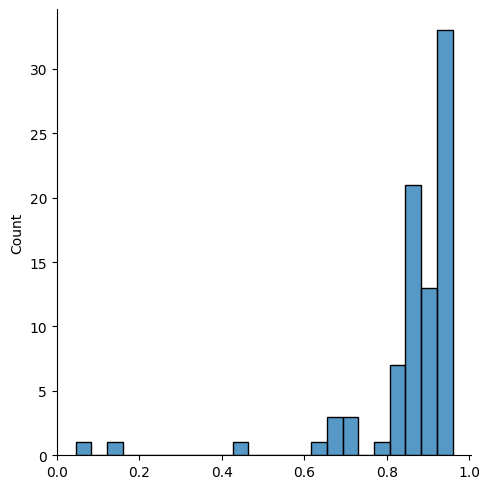

In [40]:
sns.displot(werDetectClean)

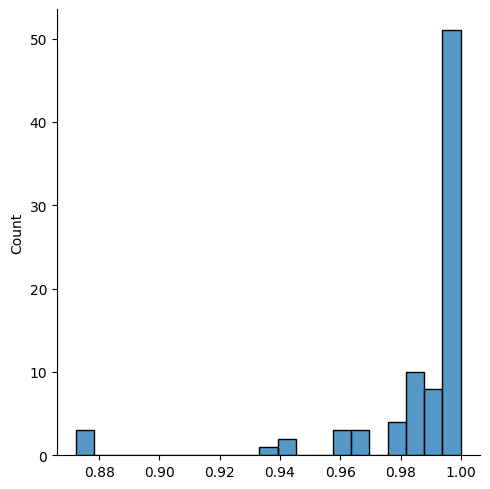

In [41]:
sns.displot(distanceDetectClean)

In [179]:
# Creating a Pandas DataFrame
df = pd.DataFrame({
    'WER Perturbed (with and without EEMD)': werDetect,
    'Levenshtein Distance Perturbed (with and without EEMD)': distanceDetect,
    'WER Clean (with and without EEMD)': werDetectClean,
    'Levenshtein Distance Clean (with and without EEMD)' : distanceDetectClean
})

In [43]:
from google.colab import files

# Save the DataFrame to an Excel file
filename = 'Detection_data.xlsx'
df.to_excel(filename, index=False)

# Download the Excel file to your local machine
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [181]:
df.head(10)

,WER Perturbed (with and without EEMD),Levenshtein Distance Perturbed (with and without EEMD),WER Clean (with and without EEMD),Levenshtein Distance Clean (with and without EEMD)
0,0.100000,0.568182,0.888889,1.000000
1,0.000000,0.439791,0.944444,1.000000
2,0.000000,0.389610,0.727273,0.872340
3,0.000000,0.350000,0.625000,0.943820
4,0.000000,0.503226,0.894737,0.988506
5,0.062500,0.503311,0.941176,1.000000
6,0.000000,0.542373,0.833333,1.000000
7,0.000000,0.593548,0.944444,1.000000
8,0.076923,0.500000,0.928571,1.000000
9,0.000000,0.562500,0.846154,0.993548


In [176]:
tempp0 = df['WER Perturbed (with and without EEMD)'].values
tempp1 = df['Levenshtein Distance Perturbed (with and without EEMD)'].values
tempp2 = df['WER Clean (with and without EEMD)'].values
tempp3 = df['Levenshtein Distance Clean (with and without EEMD)'].values

In [183]:
tempX1 = np.hstack((tempp0, tempp2))
tempX2 = np.hstack((tempp1, tempp3))

In [238]:
Y = np.hstack((np.zeros(len(tempp0)), np.ones(len(tempp2))))

In [236]:
X = np.array([tempX1, tempX2]).T
X

array([[0.1       , 0.56818182],
       [0.        , 0.43979058],
       [0.        , 0.38961039],
       [0.        , 0.35      ],
       [0.        , 0.50322581],
       [0.0625    , 0.50331126],
       [0.        , 0.54237288],
       [0.        , 0.59354839],
       [0.07692308, 0.5       ],
       [0.        , 0.5625    ],
       [0.08333333, 0.45098039],
       [0.        , 0.5875    ],
       [0.08695652, 0.50847458],
       [0.22222222, 0.59119497],
       [0.1875    , 0.65771812],
       [0.        , 0.54117647],
       [0.05      , 0.6043956 ],
       [0.18181818, 0.62385321],
       [0.        , 0.48648649],
       [0.05      , 0.53551913],
       [0.1       , 0.49090909],
       [0.        , 0.49206349],
       [0.        , 0.48648649],
       [0.18181818, 0.60550459],
       [0.11764706, 0.59354839],
       [0.        , 0.46060606],
       [0.        , 0.53333333],
       [0.        , 0.44186047],
       [0.125     , 0.71186441],
       [0.15789474, 0.56790123],
       [0.

# **IZZZZ ML ALGORITHM TIMEEEEEEEEEE**

In [275]:
%%capture
!pip install catboost

In [274]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tqdm.notebook import tqdm

In [244]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

134 out of 170 examples are used for training while the remaining 34 samples are used for testing purposes

# **DECISION TREE**

In [259]:
# Train the Decision Tree model
modelOne = DecisionTreeClassifier(random_state=42)
modelOne.fit(X_train, y_train)

# Checking the accuracy using the Test set
modelOne.score(X_test, y_test)

1.0

In [260]:
# Make predictions on the testing set
y_predOne = modelOne.predict(X_test)

# Evaluate the model performance
accuracyOne = (y_predOne == y_test).mean()
print("Accuracy:", accuracyOne)

Accuracy: 1.0


In [262]:
# Lets check this unrealistic score using some prediction
for i in tqdm(range(10)):
    example = X_test[i][np.newaxis, :]
    prediction = modelOne.predict(example)
    real_prediction = y_test[i]
    print(f"Model's prediction is {prediction[0]} and ground truth is {real_prediction}.")

  0%|          | 0/10 [00:00<?, ?it/s]

Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 0.0 and ground truth is 0.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 0.0 and ground truth is 0.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 0.0 and ground truth is 0.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 0.0 and ground truth is 0.0.


# **RANDOM FOREST**

In [248]:
# Tran a Random Forest classifier
modelTwo = RandomForestClassifier(random_state=42)
modelTwo.fit(X_train, y_train)

# Checking the accuracy using Test set
modelTwo.score(X_test, y_test)

1.0

In [249]:
# Make predictions on the testing set
y_predTwo = modelTwo.predict(X_test)

# Evaluate the model performance
accuracyTwo = (y_predTwo == y_test).mean()
print("Accuracy:", accuracyTwo)

Accuracy: 1.0


In [263]:
# Lets check this unrealistic score using some prediction
for i in tqdm(range(10)):
    example = X_test[i][np.newaxis, :]
    prediction = modelTwo.predict(example)
    real_prediction = y_test[i]
    print(f"Model's prediction is {prediction[0]} and ground truth is {real_prediction}.")

  0%|          | 0/10 [00:00<?, ?it/s]

Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 0.0 and ground truth is 0.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 0.0 and ground truth is 0.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 0.0 and ground truth is 0.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 0.0 and ground truth is 0.0.


# **XGBOOST**

In [264]:
# Train an XGBoost classifier
modelThree = XGBClassifier(random_state=42)
modelThree.fit(X_train, y_train)

# Checking the accuracy using Test set
modelThree.score(X_test, y_test)

1.0

In [265]:
# Make predictions on the testing set
y_predThree = modelThree.predict(X_test)

# Evaluate the model performance
accuracyThree = (y_predThree == y_test).mean()
print("Accuracy:", accuracyThree)

Accuracy: 1.0


In [266]:
# Lets check this unrealistic score using some prediction
for i in tqdm(range(10)):
    if i ==0:
        print('\n')
    example = X_test[i][np.newaxis, :]
    prediction = modelThree.predict(example)
    real_prediction = y_test[i]
    print(f"Model's prediction is {prediction[0]} and ground truth is {real_prediction}.")

  0%|          | 0/10 [00:00<?, ?it/s]



Model's prediction is 1 and ground truth is 1.0.
Model's prediction is 0 and ground truth is 0.0.
Model's prediction is 1 and ground truth is 1.0.
Model's prediction is 0 and ground truth is 0.0.
Model's prediction is 1 and ground truth is 1.0.
Model's prediction is 1 and ground truth is 1.0.
Model's prediction is 1 and ground truth is 1.0.
Model's prediction is 0 and ground truth is 0.0.
Model's prediction is 1 and ground truth is 1.0.
Model's prediction is 0 and ground truth is 0.0.


# **LIGHT GBM**

In [267]:
# Train an XGBoost classifier
modelFour = LGBMClassifier(random_state=42)
modelFour.fit(X_train, y_train)

# Checking the accuracy using Test set
modelFour.score(X_test, y_test)

1.0

In [268]:
# Make predictions on the testing set
y_predFour = modelFour.predict(X_test)

# Evaluate the model performance
accuracyFour = (y_predFour == y_test).mean()
print("Accuracy:", accuracyFour)

Accuracy: 1.0


In [270]:
# Lets check this unrealistic score using some prediction
for i in tqdm(range(10)):
    example = X_test[i][np.newaxis, :]
    prediction = modelFour.predict(example)
    real_prediction = y_test[i]
    print(f"Model's prediction is {prediction[0]} and ground truth is {real_prediction}.")

  0%|          | 0/10 [00:00<?, ?it/s]

Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 0.0 and ground truth is 0.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 0.0 and ground truth is 0.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 0.0 and ground truth is 0.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 0.0 and ground truth is 0.0.


# **CATBOOST**

In [271]:
# Train a CatBoost classifier
modelFive = CatBoostClassifier(random_state=42)
modelFive.fit(X_train, y_train)

# Checking the accuracy using Test set
modelFive.score(X_test, y_test)

Learning rate set to 0.004395
0:	learn: 0.6837158	total: 9.89ms	remaining: 9.88s
1:	learn: 0.6751961	total: 11.4ms	remaining: 5.67s
2:	learn: 0.6663270	total: 14.4ms	remaining: 4.79s
3:	learn: 0.6583221	total: 17.7ms	remaining: 4.4s
4:	learn: 0.6500811	total: 19.1ms	remaining: 3.8s
5:	learn: 0.6411297	total: 20.4ms	remaining: 3.38s
6:	learn: 0.6329645	total: 21.9ms	remaining: 3.11s
7:	learn: 0.6254569	total: 24.1ms	remaining: 2.99s
8:	learn: 0.6167491	total: 25.6ms	remaining: 2.81s
9:	learn: 0.6087418	total: 27.5ms	remaining: 2.72s
10:	learn: 0.6011083	total: 29.1ms	remaining: 2.62s
11:	learn: 0.5936672	total: 30.1ms	remaining: 2.48s
12:	learn: 0.5870305	total: 31.6ms	remaining: 2.4s
13:	learn: 0.5796752	total: 33.5ms	remaining: 2.36s
14:	learn: 0.5725700	total: 35ms	remaining: 2.3s
15:	learn: 0.5652775	total: 36ms	remaining: 2.21s
16:	learn: 0.5584715	total: 37.6ms	remaining: 2.17s
17:	learn: 0.5513605	total: 39.1ms	remaining: 2.13s
18:	learn: 0.5448638	total: 40.6ms	remaining: 2.09s


1.0

In [272]:
# Make predictions on the testing set
y_predFive = modelFive.predict(X_test)

# Evaluate the model performance
accuracyFive = (y_predFive == y_test).mean()
print("Accuracy:", accuracyFive)

Accuracy: 1.0


In [276]:
# Lets check this unrealistic score using some prediction
for i in tqdm(range(10)):
    example = X_test[i][np.newaxis, :]
    prediction = modelFive.predict(example)
    real_prediction = y_test[i]
    print(f"Model's prediction is {prediction[0]} and ground truth is {real_prediction}.")

  0%|          | 0/10 [00:00<?, ?it/s]

Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 0.0 and ground truth is 0.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 0.0 and ground truth is 0.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 0.0 and ground truth is 0.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 0.0 and ground truth is 0.0.


# **ADABOOST**

In [ ]:
# Train a CatBoost classifier
modelFive = CatBoostClassifier(random_state=42)
modelFive.fit(X_train, y_train)

# Checking the accuracy using Test set
modelFive.score(X_test, y_test)

In [280]:
# Create a Decision Tree classifier as base estimator
base_estimator = DecisionTreeClassifier(max_depth=2)
modelSix = AdaBoostClassifier(estimator=base_estimator)

# Train the classifier on the training data
modelSix.fit(X_train, y_train)

# Checking the accuracy using Test set
modelSix.score(X_test, y_test)

1.0

In [281]:
# Make predictions on the testing set
y_predSix = modelSix.predict(X_test)

# Evaluate the model performance
accuracySix = (y_predSix == y_test).mean()
print("Accuracy:", accuracySix)

Accuracy: 1.0


In [282]:
# Lets check this unrealistic score using some prediction
for i in tqdm(range(10)):
    example = X_test[i][np.newaxis, :]
    prediction = modelSix.predict(example)
    real_prediction = y_test[i]
    print(f"Model's prediction is {prediction[0]} and ground truth is {real_prediction}.")

  0%|          | 0/10 [00:00<?, ?it/s]

Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 0.0 and ground truth is 0.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 0.0 and ground truth is 0.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 0.0 and ground truth is 0.0.
Model's prediction is 1.0 and ground truth is 1.0.
Model's prediction is 0.0 and ground truth is 0.0.


In [284]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

modelSeven = keras.Sequential([
    layers.Dense(512, activation="relu", input_shape=(X.shape[1],)),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

modelSeven.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["accuracy"])
modelSeven.fit(X_train, y_train, epochs=20, batch_size=2)

Epoch 1/20
68/68 [==============================] - 2s 11ms/step - loss: 0.3367 - accuracy: 0.9485
Epoch 2/20
68/68 [==============================] - 1s 12ms/step - loss: 0.1714 - accuracy: 0.9632
Epoch 3/20
68/68 [==============================] - 1s 13ms/step - loss: 0.1226 - accuracy: 0.9779
Epoch 4/20
68/68 [==============================] - 1s 15ms/step - loss: 0.1093 - accuracy: 0.9779
Epoch 5/20
68/68 [==============================] - 1s 14ms/step - loss: 0.0903 - accuracy: 0.9853
Epoch 6/20
68/68 [==============================] - 1s 9ms/step - loss: 0.1069 - accuracy: 0.9779
Epoch 7/20
68/68 [==============================] - 1s 10ms/step - loss: 0.0966 - accuracy: 0.9779
Epoch 8/20
68/68 [==============================] - 1s 10ms/step - loss: 0.1124 - accuracy: 0.9632
Epoch 9/20
68/68 [==============================] - 1s 10ms/step - loss: 0.0806 - accuracy: 0.9779
Epoch 10/20
68/68 [==============================] - 1s 10ms/step - loss: 0.0797 - accuracy: 0.9779
Epoch 11/2

In [285]:
# Make predictions on the testing set
y_predSeven = modelSeven.predict(X_test)

# Evaluate the model performance
accuracySeven = (y_predSeven == y_test).mean()
print("Accuracy:", accuracyFive)

2/2 [==============================] - 0s 6ms/step
Accuracy: 1.0


In [292]:
# Lets check this unrealistic score using some prediction
for i in tqdm(range(10)):
    example = X_test[i][np.newaxis, :]
    prediction = modelSeven.predict(example)
    real_prediction = y_test[i]
    print(f"Model's prediction is {np.round(prediction[0])} and ground truth is {real_prediction}.")

  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step
Model's prediction is [1.] and ground truth is 1.0.
1/1 [==============================] - 0s 23ms/step
Model's prediction is [0.] and ground truth is 0.0.
1/1 [==============================] - 0s 28ms/step
Model's prediction is [1.] and ground truth is 1.0.
1/1 [==============================] - 0s 24ms/step
Model's prediction is [0.] and ground truth is 0.0.
1/1 [==============================] - 0s 27ms/step
Model's prediction is [1.] and ground truth is 1.0.
1/1 [==============================] - 0s 28ms/step
Model's prediction is [1.] and ground truth is 1.0.
1/1 [==============================] - 0s 22ms/step
Model's prediction is [1.] and ground truth is 1.0.
1/1 [==============================] - 0s 28ms/step
Model's prediction is [0.] and ground truth is 0.0.
1/1 [==============================] - 0s 27ms/step
Model's prediction is [1.] and ground truth is 1.0.
1/1 [==============================] - 0s 23ms/step
Model's pred

# **My Heurisitic Approach**

In [298]:
def naiveApproach(X):
    if X[0][1] < 0.85:
        return 0
    else:
        return 1

In [291]:
naivePrediction = []
for i in range(len(y_test)):
    naivePrediction.append(naiveApproach(X_test[i]))

# Evaluate the model performance
accuracyNaive = (naivePrediction == y_test).mean()
print("Accuracy:", accuracyNaive)

Accuracy: 1.0


In [302]:
# Lets check this unrealistic score using some prediction
for i in tqdm(range(10)):
    example = X_test[i][np.newaxis, :]
    prediction = naiveApproach(example)
    real_prediction = y_test[i]
    print(f"Model's prediction is {prediction} and ground truth is {real_prediction}.")

  0%|          | 0/10 [00:00<?, ?it/s]

Model's prediction is 1 and ground truth is 1.0.
Model's prediction is 0 and ground truth is 0.0.
Model's prediction is 1 and ground truth is 1.0.
Model's prediction is 0 and ground truth is 0.0.
Model's prediction is 1 and ground truth is 1.0.
Model's prediction is 1 and ground truth is 1.0.
Model's prediction is 1 and ground truth is 1.0.
Model's prediction is 0 and ground truth is 0.0.
Model's prediction is 1 and ground truth is 1.0.
Model's prediction is 0 and ground truth is 0.0.
